In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "int99"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 288
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 360
Categorical Columns: 8


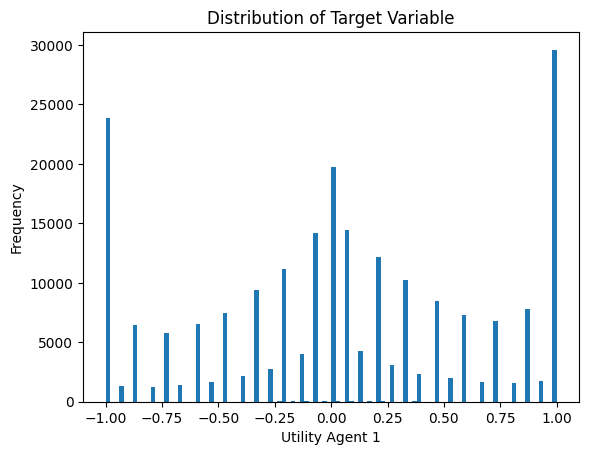

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6131332	test: 0.5507167	best: 0.5507167 (0)	total: 168ms	remaining: 8m 24s


50:	learn: 0.3825977	test: 0.4644091	best: 0.4643722 (47)	total: 5.17s	remaining: 4m 58s


100:	learn: 0.3406731	test: 0.4460580	best: 0.4460580 (100)	total: 10.5s	remaining: 5m


150:	learn: 0.3194396	test: 0.4382758	best: 0.4382758 (150)	total: 15.8s	remaining: 4m 58s


200:	learn: 0.3031576	test: 0.4336641	best: 0.4336641 (200)	total: 21.2s	remaining: 4m 54s


250:	learn: 0.2915617	test: 0.4312895	best: 0.4312895 (250)	total: 26.6s	remaining: 4m 50s


300:	learn: 0.2826298	test: 0.4290852	best: 0.4290852 (300)	total: 32s	remaining: 4m 46s


350:	learn: 0.2746225	test: 0.4277227	best: 0.4277227 (350)	total: 37.3s	remaining: 4m 41s


400:	learn: 0.2677463	test: 0.4267299	best: 0.4267299 (400)	total: 42.7s	remaining: 4m 36s


450:	learn: 0.2617601	test: 0.4258689	best: 0.4258689 (450)	total: 48.2s	remaining: 4m 32s


500:	learn: 0.2564489	test: 0.4247787	best: 0.4247787 (500)	total: 53.7s	remaining: 4m 27s


550:	learn: 0.2518479	test: 0.4240835	best: 0.4240835 (550)	total: 59.1s	remaining: 4m 22s


600:	learn: 0.2476206	test: 0.4234004	best: 0.4234004 (600)	total: 1m 4s	remaining: 4m 17s


650:	learn: 0.2436140	test: 0.4229697	best: 0.4229697 (650)	total: 1m 9s	remaining: 4m 12s


700:	learn: 0.2399480	test: 0.4225579	best: 0.4225388 (689)	total: 1m 15s	remaining: 4m 7s


750:	learn: 0.2365196	test: 0.4220812	best: 0.4220712 (746)	total: 1m 20s	remaining: 4m 1s


800:	learn: 0.2332466	test: 0.4219769	best: 0.4219280 (781)	total: 1m 26s	remaining: 3m 56s


850:	learn: 0.2302117	test: 0.4218586	best: 0.4218483 (832)	total: 1m 31s	remaining: 3m 51s


900:	learn: 0.2274175	test: 0.4218672	best: 0.4218228 (880)	total: 1m 36s	remaining: 3m 45s


950:	learn: 0.2246180	test: 0.4218671	best: 0.4218099 (905)	total: 1m 42s	remaining: 3m 40s


1000:	learn: 0.2222460	test: 0.4217212	best: 0.4216909 (962)	total: 1m 47s	remaining: 3m 35s


1050:	learn: 0.2198149	test: 0.4216489	best: 0.4216024 (1011)	total: 1m 53s	remaining: 3m 30s


1100:	learn: 0.2171881	test: 0.4213785	best: 0.4213785 (1100)	total: 1m 58s	remaining: 3m 24s


1150:	learn: 0.2148121	test: 0.4212254	best: 0.4212254 (1150)	total: 2m 3s	remaining: 3m 19s


1200:	learn: 0.2125886	test: 0.4211167	best: 0.4211046 (1199)	total: 2m 9s	remaining: 3m 13s


1250:	learn: 0.2105222	test: 0.4208980	best: 0.4208980 (1250)	total: 2m 14s	remaining: 3m 8s


1300:	learn: 0.2083386	test: 0.4208349	best: 0.4208301 (1298)	total: 2m 20s	remaining: 3m 3s


1350:	learn: 0.2063539	test: 0.4208048	best: 0.4207380 (1320)	total: 2m 25s	remaining: 2m 57s


1400:	learn: 0.2044598	test: 0.4207183	best: 0.4206999 (1396)	total: 2m 31s	remaining: 2m 52s


1450:	learn: 0.2024906	test: 0.4207061	best: 0.4206999 (1396)	total: 2m 36s	remaining: 2m 47s


1500:	learn: 0.2006906	test: 0.4205679	best: 0.4205612 (1491)	total: 2m 41s	remaining: 2m 41s


1550:	learn: 0.1988711	test: 0.4206083	best: 0.4205291 (1526)	total: 2m 47s	remaining: 2m 36s


1600:	learn: 0.1973400	test: 0.4206236	best: 0.4205291 (1526)	total: 2m 52s	remaining: 2m 30s


1650:	learn: 0.1954890	test: 0.4205626	best: 0.4205291 (1526)	total: 2m 58s	remaining: 2m 25s


1700:	learn: 0.1938267	test: 0.4205587	best: 0.4205291 (1526)	total: 3m 3s	remaining: 2m 20s


1750:	learn: 0.1922615	test: 0.4205936	best: 0.4205291 (1526)	total: 3m 8s	remaining: 2m 14s


1800:	learn: 0.1907039	test: 0.4206800	best: 0.4205291 (1526)	total: 3m 14s	remaining: 2m 9s


1850:	learn: 0.1893261	test: 0.4207113	best: 0.4205291 (1526)	total: 3m 19s	remaining: 2m 3s


1900:	learn: 0.1878506	test: 0.4206371	best: 0.4205291 (1526)	total: 3m 24s	remaining: 1m 58s


1950:	learn: 0.1864795	test: 0.4206994	best: 0.4205291 (1526)	total: 3m 30s	remaining: 1m 53s


2000:	learn: 0.1849434	test: 0.4207625	best: 0.4205291 (1526)	total: 3m 35s	remaining: 1m 47s


2050:	learn: 0.1836155	test: 0.4206522	best: 0.4205291 (1526)	total: 3m 41s	remaining: 1m 42s


2100:	learn: 0.1823356	test: 0.4206691	best: 0.4205291 (1526)	total: 3m 46s	remaining: 1m 36s


2150:	learn: 0.1809554	test: 0.4206983	best: 0.4205291 (1526)	total: 3m 52s	remaining: 1m 31s


2200:	learn: 0.1796549	test: 0.4207037	best: 0.4205291 (1526)	total: 3m 57s	remaining: 1m 26s


2250:	learn: 0.1783482	test: 0.4205908	best: 0.4205291 (1526)	total: 4m 2s	remaining: 1m 20s


2300:	learn: 0.1771271	test: 0.4205619	best: 0.4205291 (1526)	total: 4m 8s	remaining: 1m 15s


2350:	learn: 0.1758353	test: 0.4205419	best: 0.4205291 (1526)	total: 4m 13s	remaining: 1m 10s


2400:	learn: 0.1747460	test: 0.4204684	best: 0.4204661 (2398)	total: 4m 19s	remaining: 1m 4s


2450:	learn: 0.1733976	test: 0.4204258	best: 0.4204014 (2431)	total: 4m 24s	remaining: 59.2s


2500:	learn: 0.1722028	test: 0.4204364	best: 0.4204004 (2459)	total: 4m 29s	remaining: 53.8s


2550:	learn: 0.1709139	test: 0.4203378	best: 0.4203295 (2543)	total: 4m 35s	remaining: 48.5s


2600:	learn: 0.1697252	test: 0.4203167	best: 0.4202918 (2563)	total: 4m 40s	remaining: 43.1s


2650:	learn: 0.1684724	test: 0.4203218	best: 0.4202918 (2563)	total: 4m 46s	remaining: 37.7s


2700:	learn: 0.1673801	test: 0.4203293	best: 0.4202874 (2686)	total: 4m 51s	remaining: 32.3s


2750:	learn: 0.1662369	test: 0.4203080	best: 0.4202874 (2686)	total: 4m 56s	remaining: 26.9s


2800:	learn: 0.1651746	test: 0.4202650	best: 0.4202319 (2780)	total: 5m 2s	remaining: 21.5s


2850:	learn: 0.1640324	test: 0.4202894	best: 0.4202319 (2780)	total: 5m 7s	remaining: 16.1s


2900:	learn: 0.1630363	test: 0.4203325	best: 0.4202319 (2780)	total: 5m 13s	remaining: 10.7s


2950:	learn: 0.1620866	test: 0.4203795	best: 0.4202319 (2780)	total: 5m 18s	remaining: 5.29s


2999:	learn: 0.1610801	test: 0.4203632	best: 0.4202319 (2780)	total: 5m 24s	remaining: 0us

bestTest = 0.4202318783
bestIteration = 2780

Shrink model to first 2781 iterations.


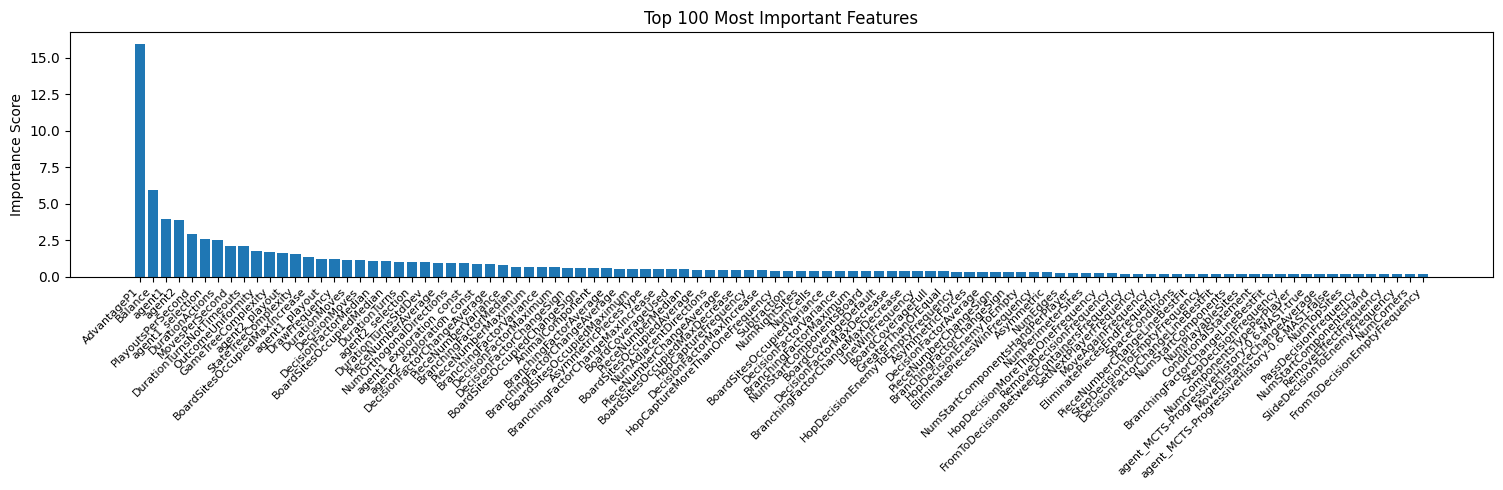

Fold 1 - RMSE: 0.4198725737074144
Fold 2


0:	learn: 0.6073886	test: 0.5840626	best: 0.5840626 (0)	total: 101ms	remaining: 5m 3s


50:	learn: 0.3860427	test: 0.4808181	best: 0.4808181 (50)	total: 5.22s	remaining: 5m 2s


100:	learn: 0.3481766	test: 0.4695918	best: 0.4695918 (100)	total: 10.7s	remaining: 5m 6s


150:	learn: 0.3254448	test: 0.4628476	best: 0.4627074 (149)	total: 16.1s	remaining: 5m 4s


200:	learn: 0.3097785	test: 0.4591524	best: 0.4591315 (198)	total: 21.6s	remaining: 5m


250:	learn: 0.2979623	test: 0.4566712	best: 0.4566712 (250)	total: 27s	remaining: 4m 55s


300:	learn: 0.2886444	test: 0.4544445	best: 0.4544445 (300)	total: 32.4s	remaining: 4m 50s


350:	learn: 0.2808107	test: 0.4535163	best: 0.4535163 (350)	total: 37.9s	remaining: 4m 46s


400:	learn: 0.2734363	test: 0.4526734	best: 0.4526714 (399)	total: 43.4s	remaining: 4m 41s


450:	learn: 0.2674301	test: 0.4517734	best: 0.4517472 (448)	total: 48.9s	remaining: 4m 36s


500:	learn: 0.2622284	test: 0.4515384	best: 0.4515247 (473)	total: 54.4s	remaining: 4m 31s


550:	learn: 0.2575819	test: 0.4513110	best: 0.4512337 (518)	total: 1m	remaining: 4m 26s


600:	learn: 0.2529858	test: 0.4508836	best: 0.4508113 (595)	total: 1m 5s	remaining: 4m 22s


650:	learn: 0.2486874	test: 0.4501031	best: 0.4501031 (650)	total: 1m 11s	remaining: 4m 16s


700:	learn: 0.2449421	test: 0.4493580	best: 0.4493580 (700)	total: 1m 16s	remaining: 4m 11s


750:	learn: 0.2414178	test: 0.4494055	best: 0.4492354 (736)	total: 1m 22s	remaining: 4m 6s


800:	learn: 0.2384434	test: 0.4492044	best: 0.4492040 (799)	total: 1m 27s	remaining: 4m 1s


850:	learn: 0.2355209	test: 0.4492495	best: 0.4491284 (811)	total: 1m 33s	remaining: 3m 56s


900:	learn: 0.2325594	test: 0.4490264	best: 0.4490264 (900)	total: 1m 39s	remaining: 3m 50s


950:	learn: 0.2298600	test: 0.4487486	best: 0.4487486 (950)	total: 1m 44s	remaining: 3m 45s


1000:	learn: 0.2271281	test: 0.4485791	best: 0.4485330 (999)	total: 1m 50s	remaining: 3m 40s


1050:	learn: 0.2243168	test: 0.4483545	best: 0.4483467 (1047)	total: 1m 55s	remaining: 3m 34s


1100:	learn: 0.2220011	test: 0.4483781	best: 0.4482848 (1066)	total: 2m 1s	remaining: 3m 29s


1150:	learn: 0.2198257	test: 0.4482698	best: 0.4482627 (1147)	total: 2m 7s	remaining: 3m 24s


1200:	learn: 0.2176748	test: 0.4481871	best: 0.4481209 (1163)	total: 2m 12s	remaining: 3m 18s


1250:	learn: 0.2155215	test: 0.4480247	best: 0.4480162 (1249)	total: 2m 18s	remaining: 3m 13s


1300:	learn: 0.2134401	test: 0.4479561	best: 0.4479454 (1264)	total: 2m 23s	remaining: 3m 7s


1350:	learn: 0.2114425	test: 0.4479631	best: 0.4479136 (1312)	total: 2m 29s	remaining: 3m 2s


1400:	learn: 0.2096963	test: 0.4479015	best: 0.4479015 (1400)	total: 2m 35s	remaining: 2m 57s


1450:	learn: 0.2077221	test: 0.4477723	best: 0.4477723 (1450)	total: 2m 40s	remaining: 2m 51s


1500:	learn: 0.2060471	test: 0.4477802	best: 0.4477187 (1482)	total: 2m 46s	remaining: 2m 46s


1550:	learn: 0.2044709	test: 0.4476453	best: 0.4476297 (1547)	total: 2m 52s	remaining: 2m 40s


1600:	learn: 0.2027032	test: 0.4476502	best: 0.4476112 (1595)	total: 2m 57s	remaining: 2m 35s


1650:	learn: 0.2009830	test: 0.4476970	best: 0.4476112 (1595)	total: 3m 3s	remaining: 2m 29s


1700:	learn: 0.1994426	test: 0.4476425	best: 0.4476112 (1595)	total: 3m 8s	remaining: 2m 24s


1750:	learn: 0.1978827	test: 0.4476721	best: 0.4476112 (1595)	total: 3m 14s	remaining: 2m 18s


1800:	learn: 0.1963235	test: 0.4477739	best: 0.4476112 (1595)	total: 3m 20s	remaining: 2m 13s


1850:	learn: 0.1947822	test: 0.4477565	best: 0.4476112 (1595)	total: 3m 25s	remaining: 2m 7s


1900:	learn: 0.1933505	test: 0.4476562	best: 0.4476112 (1595)	total: 3m 31s	remaining: 2m 2s


1950:	learn: 0.1917573	test: 0.4475574	best: 0.4475497 (1948)	total: 3m 36s	remaining: 1m 56s


2000:	learn: 0.1903099	test: 0.4476014	best: 0.4475467 (1954)	total: 3m 42s	remaining: 1m 50s


2050:	learn: 0.1889356	test: 0.4476011	best: 0.4475467 (1954)	total: 3m 47s	remaining: 1m 45s


2100:	learn: 0.1876218	test: 0.4476280	best: 0.4475467 (1954)	total: 3m 53s	remaining: 1m 39s


2150:	learn: 0.1862001	test: 0.4476630	best: 0.4475467 (1954)	total: 3m 59s	remaining: 1m 34s


2200:	learn: 0.1849217	test: 0.4475692	best: 0.4475467 (1954)	total: 4m 4s	remaining: 1m 28s


2250:	learn: 0.1835895	test: 0.4475509	best: 0.4475467 (1954)	total: 4m 10s	remaining: 1m 23s


2300:	learn: 0.1823787	test: 0.4475213	best: 0.4475090 (2266)	total: 4m 16s	remaining: 1m 17s


2350:	learn: 0.1812767	test: 0.4475743	best: 0.4475090 (2266)	total: 4m 21s	remaining: 1m 12s


2400:	learn: 0.1800637	test: 0.4475718	best: 0.4475090 (2266)	total: 4m 27s	remaining: 1m 6s


2450:	learn: 0.1788721	test: 0.4475814	best: 0.4475090 (2266)	total: 4m 32s	remaining: 1m 1s


2500:	learn: 0.1778056	test: 0.4476269	best: 0.4475090 (2266)	total: 4m 38s	remaining: 55.6s


2550:	learn: 0.1765409	test: 0.4476027	best: 0.4475090 (2266)	total: 4m 44s	remaining: 50s


2600:	learn: 0.1754074	test: 0.4476205	best: 0.4475090 (2266)	total: 4m 49s	remaining: 44.5s


2650:	learn: 0.1742560	test: 0.4475727	best: 0.4475090 (2266)	total: 4m 55s	remaining: 38.9s


2700:	learn: 0.1732182	test: 0.4475515	best: 0.4475090 (2266)	total: 5m	remaining: 33.3s


2750:	learn: 0.1722127	test: 0.4475253	best: 0.4475090 (2266)	total: 5m 6s	remaining: 27.7s


2800:	learn: 0.1710311	test: 0.4474829	best: 0.4474710 (2767)	total: 5m 12s	remaining: 22.2s


2850:	learn: 0.1700090	test: 0.4474100	best: 0.4474100 (2850)	total: 5m 17s	remaining: 16.6s


2900:	learn: 0.1689701	test: 0.4473788	best: 0.4473742 (2899)	total: 5m 23s	remaining: 11s


2950:	learn: 0.1679360	test: 0.4473967	best: 0.4473425 (2907)	total: 5m 29s	remaining: 5.46s


2999:	learn: 0.1668882	test: 0.4473702	best: 0.4473425 (2907)	total: 5m 34s	remaining: 0us

bestTest = 0.4473424768
bestIteration = 2907

Shrink model to first 2908 iterations.


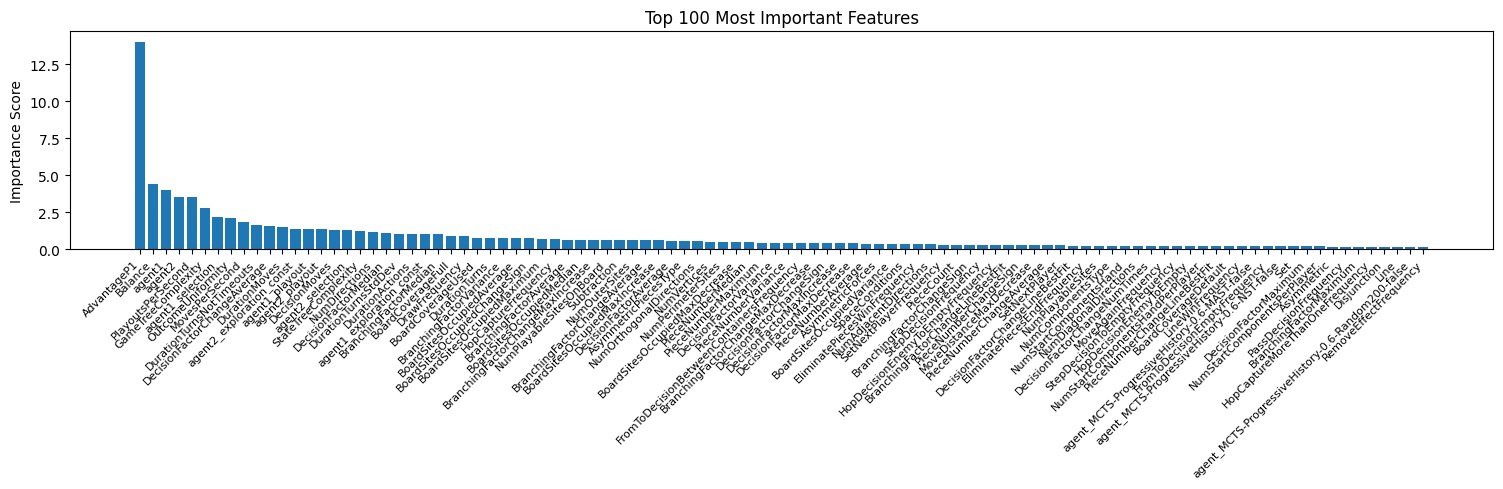

Fold 2 - RMSE: 0.44687447495424704
Fold 3


0:	learn: 0.6024466	test: 0.5968112	best: 0.5968112 (0)	total: 97.3ms	remaining: 4m 51s


50:	learn: 0.3904049	test: 0.4683955	best: 0.4683955 (50)	total: 5.33s	remaining: 5m 8s


100:	learn: 0.3512199	test: 0.4516059	best: 0.4516059 (100)	total: 10.9s	remaining: 5m 12s


150:	learn: 0.3271349	test: 0.4426530	best: 0.4426530 (150)	total: 16.3s	remaining: 5m 7s


200:	learn: 0.3116851	test: 0.4385085	best: 0.4385085 (200)	total: 21.8s	remaining: 5m 3s


250:	learn: 0.3001534	test: 0.4365552	best: 0.4365397 (247)	total: 27.3s	remaining: 4m 59s


300:	learn: 0.2905832	test: 0.4355687	best: 0.4354590 (298)	total: 32.8s	remaining: 4m 54s


350:	learn: 0.2822349	test: 0.4345612	best: 0.4345529 (349)	total: 38.3s	remaining: 4m 48s


400:	learn: 0.2744259	test: 0.4338213	best: 0.4338213 (400)	total: 43.8s	remaining: 4m 43s


450:	learn: 0.2681843	test: 0.4325299	best: 0.4325140 (449)	total: 49.3s	remaining: 4m 38s


500:	learn: 0.2625192	test: 0.4315492	best: 0.4315177 (498)	total: 54.8s	remaining: 4m 33s


550:	learn: 0.2575936	test: 0.4312497	best: 0.4312497 (550)	total: 1m	remaining: 4m 28s


600:	learn: 0.2532992	test: 0.4307449	best: 0.4307449 (600)	total: 1m 6s	remaining: 4m 23s


650:	learn: 0.2492455	test: 0.4302235	best: 0.4302235 (650)	total: 1m 11s	remaining: 4m 18s


700:	learn: 0.2453339	test: 0.4300467	best: 0.4299717 (681)	total: 1m 17s	remaining: 4m 13s


750:	learn: 0.2417520	test: 0.4297159	best: 0.4297026 (745)	total: 1m 22s	remaining: 4m 7s


800:	learn: 0.2384128	test: 0.4295183	best: 0.4294674 (792)	total: 1m 28s	remaining: 4m 2s


850:	learn: 0.2351559	test: 0.4295069	best: 0.4294333 (822)	total: 1m 33s	remaining: 3m 56s


900:	learn: 0.2325266	test: 0.4295081	best: 0.4294333 (822)	total: 1m 39s	remaining: 3m 51s


950:	learn: 0.2298982	test: 0.4295620	best: 0.4294333 (822)	total: 1m 44s	remaining: 3m 46s


1000:	learn: 0.2274405	test: 0.4292872	best: 0.4292575 (994)	total: 1m 50s	remaining: 3m 40s


1050:	learn: 0.2249114	test: 0.4290218	best: 0.4290218 (1050)	total: 1m 56s	remaining: 3m 35s


1100:	learn: 0.2223138	test: 0.4289810	best: 0.4288496 (1083)	total: 2m 1s	remaining: 3m 29s


1150:	learn: 0.2198738	test: 0.4286542	best: 0.4286542 (1150)	total: 2m 7s	remaining: 3m 24s


1200:	learn: 0.2178092	test: 0.4286739	best: 0.4286001 (1182)	total: 2m 13s	remaining: 3m 19s


1250:	learn: 0.2157653	test: 0.4285678	best: 0.4285423 (1228)	total: 2m 18s	remaining: 3m 13s


1300:	learn: 0.2135661	test: 0.4284803	best: 0.4284803 (1300)	total: 2m 23s	remaining: 3m 7s


1350:	learn: 0.2116607	test: 0.4283261	best: 0.4283261 (1350)	total: 2m 29s	remaining: 3m 2s


1400:	learn: 0.2099340	test: 0.4282150	best: 0.4282150 (1400)	total: 2m 35s	remaining: 2m 57s


1450:	learn: 0.2083097	test: 0.4281633	best: 0.4281225 (1432)	total: 2m 40s	remaining: 2m 51s


1500:	learn: 0.2064723	test: 0.4281074	best: 0.4280786 (1469)	total: 2m 46s	remaining: 2m 46s


1550:	learn: 0.2048373	test: 0.4279652	best: 0.4279248 (1539)	total: 2m 51s	remaining: 2m 40s


1600:	learn: 0.2030754	test: 0.4278560	best: 0.4278560 (1600)	total: 2m 57s	remaining: 2m 35s


1650:	learn: 0.2012473	test: 0.4277617	best: 0.4277330 (1637)	total: 3m 2s	remaining: 2m 29s


1700:	learn: 0.1997300	test: 0.4277284	best: 0.4276686 (1673)	total: 3m 8s	remaining: 2m 24s


1750:	learn: 0.1982202	test: 0.4277098	best: 0.4276686 (1673)	total: 3m 14s	remaining: 2m 18s


1800:	learn: 0.1967292	test: 0.4275882	best: 0.4275841 (1799)	total: 3m 19s	remaining: 2m 12s


1850:	learn: 0.1951569	test: 0.4275420	best: 0.4275376 (1847)	total: 3m 25s	remaining: 2m 7s


1900:	learn: 0.1935567	test: 0.4276590	best: 0.4275376 (1847)	total: 3m 30s	remaining: 2m 1s


1950:	learn: 0.1922116	test: 0.4276121	best: 0.4275376 (1847)	total: 3m 36s	remaining: 1m 56s


2000:	learn: 0.1908672	test: 0.4275697	best: 0.4275376 (1847)	total: 3m 42s	remaining: 1m 50s


2050:	learn: 0.1892649	test: 0.4276336	best: 0.4275376 (1847)	total: 3m 47s	remaining: 1m 45s


2100:	learn: 0.1877562	test: 0.4276376	best: 0.4275376 (1847)	total: 3m 52s	remaining: 1m 39s


2150:	learn: 0.1863679	test: 0.4276292	best: 0.4275376 (1847)	total: 3m 58s	remaining: 1m 34s


2200:	learn: 0.1850275	test: 0.4275651	best: 0.4275376 (1847)	total: 4m 4s	remaining: 1m 28s


2250:	learn: 0.1837431	test: 0.4275546	best: 0.4275337 (2211)	total: 4m 9s	remaining: 1m 23s


2300:	learn: 0.1824427	test: 0.4275194	best: 0.4275122 (2285)	total: 4m 15s	remaining: 1m 17s


2350:	learn: 0.1811692	test: 0.4274739	best: 0.4274739 (2350)	total: 4m 20s	remaining: 1m 12s


2400:	learn: 0.1799766	test: 0.4273874	best: 0.4273838 (2395)	total: 4m 26s	remaining: 1m 6s


2450:	learn: 0.1787188	test: 0.4273653	best: 0.4273581 (2432)	total: 4m 32s	remaining: 1m


2500:	learn: 0.1774972	test: 0.4273277	best: 0.4273184 (2490)	total: 4m 37s	remaining: 55.4s


2550:	learn: 0.1762894	test: 0.4273995	best: 0.4273184 (2490)	total: 4m 43s	remaining: 49.9s


2600:	learn: 0.1750778	test: 0.4273959	best: 0.4273184 (2490)	total: 4m 48s	remaining: 44.3s


2650:	learn: 0.1739435	test: 0.4273303	best: 0.4273172 (2648)	total: 4m 54s	remaining: 38.7s


2700:	learn: 0.1727717	test: 0.4273736	best: 0.4273172 (2648)	total: 4m 59s	remaining: 33.2s


2750:	learn: 0.1716400	test: 0.4273920	best: 0.4273172 (2648)	total: 5m 5s	remaining: 27.6s


2800:	learn: 0.1704483	test: 0.4273189	best: 0.4273084 (2790)	total: 5m 11s	remaining: 22.1s


2850:	learn: 0.1692953	test: 0.4273040	best: 0.4273040 (2850)	total: 5m 16s	remaining: 16.5s


2900:	learn: 0.1681693	test: 0.4273200	best: 0.4272915 (2852)	total: 5m 22s	remaining: 11s


2950:	learn: 0.1671251	test: 0.4272911	best: 0.4272724 (2942)	total: 5m 27s	remaining: 5.44s


2999:	learn: 0.1660448	test: 0.4273338	best: 0.4272724 (2942)	total: 5m 33s	remaining: 0us

bestTest = 0.427272379
bestIteration = 2942

Shrink model to first 2943 iterations.


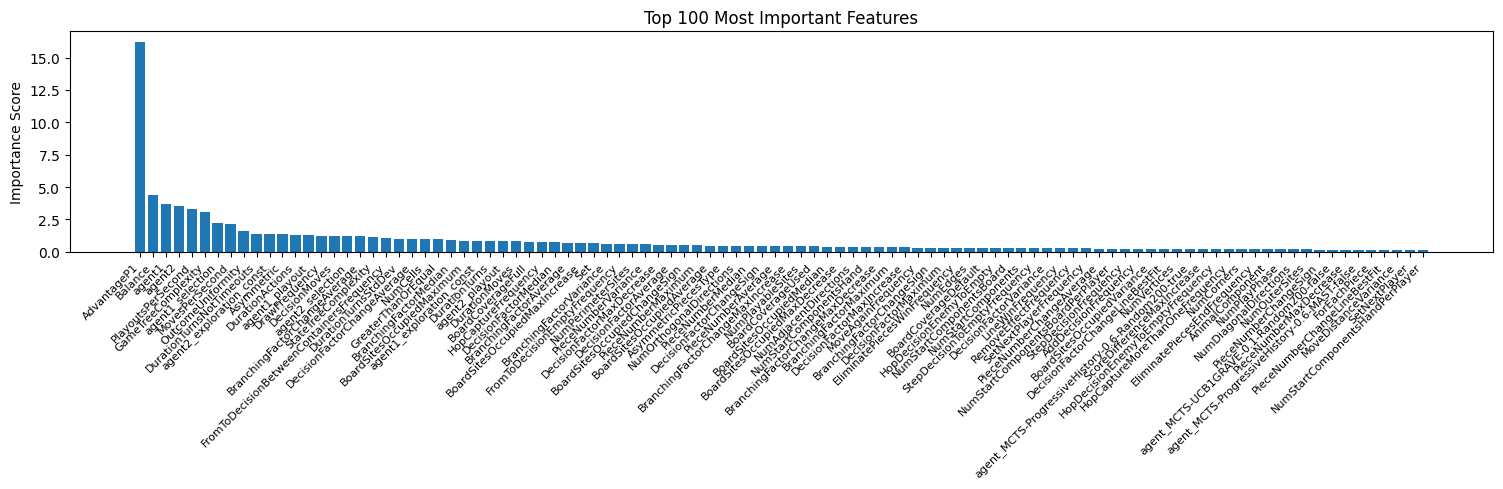

Fold 3 - RMSE: 0.42664369277439135
Fold 4


0:	learn: 0.6048597	test: 0.5854066	best: 0.5854066 (0)	total: 97.8ms	remaining: 4m 53s


50:	learn: 0.3892975	test: 0.4856249	best: 0.4856249 (50)	total: 5.11s	remaining: 4m 55s


100:	learn: 0.3494337	test: 0.4667480	best: 0.4667480 (100)	total: 10.6s	remaining: 5m 5s


150:	learn: 0.3262664	test: 0.4574902	best: 0.4574902 (150)	total: 16s	remaining: 5m 1s


200:	learn: 0.3103260	test: 0.4532574	best: 0.4532574 (200)	total: 21.4s	remaining: 4m 58s


250:	learn: 0.2984199	test: 0.4510641	best: 0.4510641 (250)	total: 26.9s	remaining: 4m 54s


300:	learn: 0.2879407	test: 0.4483713	best: 0.4483713 (300)	total: 32.2s	remaining: 4m 49s


350:	learn: 0.2790729	test: 0.4470281	best: 0.4470281 (350)	total: 37.6s	remaining: 4m 43s


400:	learn: 0.2721691	test: 0.4456834	best: 0.4456834 (400)	total: 43.1s	remaining: 4m 39s


450:	learn: 0.2658756	test: 0.4452835	best: 0.4452251 (448)	total: 48.5s	remaining: 4m 34s


500:	learn: 0.2603933	test: 0.4445094	best: 0.4445094 (500)	total: 53.8s	remaining: 4m 28s


550:	learn: 0.2551629	test: 0.4439067	best: 0.4438613 (549)	total: 59.3s	remaining: 4m 23s


600:	learn: 0.2504725	test: 0.4438839	best: 0.4437987 (585)	total: 1m 4s	remaining: 4m 18s


650:	learn: 0.2462811	test: 0.4433614	best: 0.4433572 (649)	total: 1m 10s	remaining: 4m 13s


700:	learn: 0.2425536	test: 0.4427234	best: 0.4427200 (699)	total: 1m 15s	remaining: 4m 8s


750:	learn: 0.2390808	test: 0.4424479	best: 0.4424479 (750)	total: 1m 21s	remaining: 4m 3s


800:	learn: 0.2357894	test: 0.4421199	best: 0.4421112 (798)	total: 1m 26s	remaining: 3m 57s


850:	learn: 0.2326331	test: 0.4418488	best: 0.4418358 (848)	total: 1m 32s	remaining: 3m 52s


900:	learn: 0.2299655	test: 0.4415928	best: 0.4415739 (894)	total: 1m 37s	remaining: 3m 47s


950:	learn: 0.2272188	test: 0.4413799	best: 0.4413799 (950)	total: 1m 43s	remaining: 3m 42s


1000:	learn: 0.2246615	test: 0.4412966	best: 0.4412252 (982)	total: 1m 48s	remaining: 3m 36s


1050:	learn: 0.2224467	test: 0.4410932	best: 0.4410932 (1050)	total: 1m 54s	remaining: 3m 31s


1100:	learn: 0.2201930	test: 0.4410427	best: 0.4409896 (1069)	total: 1m 59s	remaining: 3m 26s


1150:	learn: 0.2180835	test: 0.4410404	best: 0.4409524 (1142)	total: 2m 5s	remaining: 3m 21s


1200:	learn: 0.2157575	test: 0.4408281	best: 0.4408203 (1198)	total: 2m 10s	remaining: 3m 15s


1250:	learn: 0.2138168	test: 0.4406534	best: 0.4406532 (1249)	total: 2m 16s	remaining: 3m 10s


1300:	learn: 0.2119373	test: 0.4406165	best: 0.4405999 (1257)	total: 2m 21s	remaining: 3m 5s


1350:	learn: 0.2099729	test: 0.4405412	best: 0.4405223 (1346)	total: 2m 27s	remaining: 2m 59s


1400:	learn: 0.2078875	test: 0.4404825	best: 0.4404727 (1398)	total: 2m 32s	remaining: 2m 54s


1450:	learn: 0.2060415	test: 0.4404490	best: 0.4403961 (1429)	total: 2m 38s	remaining: 2m 49s


1500:	learn: 0.2040847	test: 0.4403503	best: 0.4403427 (1498)	total: 2m 43s	remaining: 2m 43s


1550:	learn: 0.2023957	test: 0.4403271	best: 0.4402798 (1539)	total: 2m 49s	remaining: 2m 38s


1600:	learn: 0.2007785	test: 0.4402955	best: 0.4402411 (1567)	total: 2m 54s	remaining: 2m 32s


1650:	learn: 0.1992410	test: 0.4402382	best: 0.4402241 (1644)	total: 3m	remaining: 2m 27s


1700:	learn: 0.1976190	test: 0.4401107	best: 0.4401107 (1700)	total: 3m 6s	remaining: 2m 22s


1750:	learn: 0.1961025	test: 0.4401350	best: 0.4400776 (1712)	total: 3m 11s	remaining: 2m 16s


1800:	learn: 0.1945393	test: 0.4400946	best: 0.4400695 (1775)	total: 3m 17s	remaining: 2m 11s


1850:	learn: 0.1931230	test: 0.4400585	best: 0.4400399 (1842)	total: 3m 22s	remaining: 2m 5s


1900:	learn: 0.1917378	test: 0.4400181	best: 0.4400156 (1899)	total: 3m 28s	remaining: 2m


1950:	learn: 0.1903239	test: 0.4400173	best: 0.4400120 (1917)	total: 3m 33s	remaining: 1m 54s


2000:	learn: 0.1888927	test: 0.4399425	best: 0.4399242 (1990)	total: 3m 39s	remaining: 1m 49s


2050:	learn: 0.1874601	test: 0.4399539	best: 0.4399181 (2007)	total: 3m 44s	remaining: 1m 44s


2100:	learn: 0.1860259	test: 0.4399232	best: 0.4399172 (2090)	total: 3m 50s	remaining: 1m 38s


2150:	learn: 0.1847005	test: 0.4399591	best: 0.4399137 (2105)	total: 3m 55s	remaining: 1m 33s


2200:	learn: 0.1833342	test: 0.4399280	best: 0.4399137 (2105)	total: 4m 1s	remaining: 1m 27s


2250:	learn: 0.1819181	test: 0.4398616	best: 0.4398611 (2248)	total: 4m 7s	remaining: 1m 22s


2300:	learn: 0.1806539	test: 0.4397958	best: 0.4397936 (2297)	total: 4m 12s	remaining: 1m 16s


2350:	learn: 0.1794634	test: 0.4397959	best: 0.4397545 (2314)	total: 4m 18s	remaining: 1m 11s


2400:	learn: 0.1782427	test: 0.4397504	best: 0.4397480 (2399)	total: 4m 23s	remaining: 1m 5s


2450:	learn: 0.1771242	test: 0.4396819	best: 0.4396819 (2450)	total: 4m 29s	remaining: 1m


2500:	learn: 0.1759388	test: 0.4396852	best: 0.4396754 (2492)	total: 4m 34s	remaining: 54.8s


2550:	learn: 0.1747941	test: 0.4396527	best: 0.4396487 (2511)	total: 4m 40s	remaining: 49.4s


2600:	learn: 0.1735818	test: 0.4397014	best: 0.4396382 (2554)	total: 4m 45s	remaining: 43.9s


2650:	learn: 0.1724431	test: 0.4397073	best: 0.4396382 (2554)	total: 4m 51s	remaining: 38.4s


2700:	learn: 0.1713639	test: 0.4396499	best: 0.4396382 (2554)	total: 4m 56s	remaining: 32.9s


2750:	learn: 0.1702247	test: 0.4397053	best: 0.4396382 (2554)	total: 5m 2s	remaining: 27.4s


2800:	learn: 0.1691786	test: 0.4396894	best: 0.4396382 (2554)	total: 5m 8s	remaining: 21.9s


2850:	learn: 0.1683019	test: 0.4396706	best: 0.4396382 (2554)	total: 5m 13s	remaining: 16.4s


2900:	learn: 0.1672430	test: 0.4396448	best: 0.4396374 (2895)	total: 5m 19s	remaining: 10.9s


2950:	learn: 0.1662208	test: 0.4396658	best: 0.4396374 (2895)	total: 5m 24s	remaining: 5.39s


2999:	learn: 0.1652218	test: 0.4396834	best: 0.4396374 (2895)	total: 5m 30s	remaining: 0us

bestTest = 0.4396374075
bestIteration = 2895

Shrink model to first 2896 iterations.


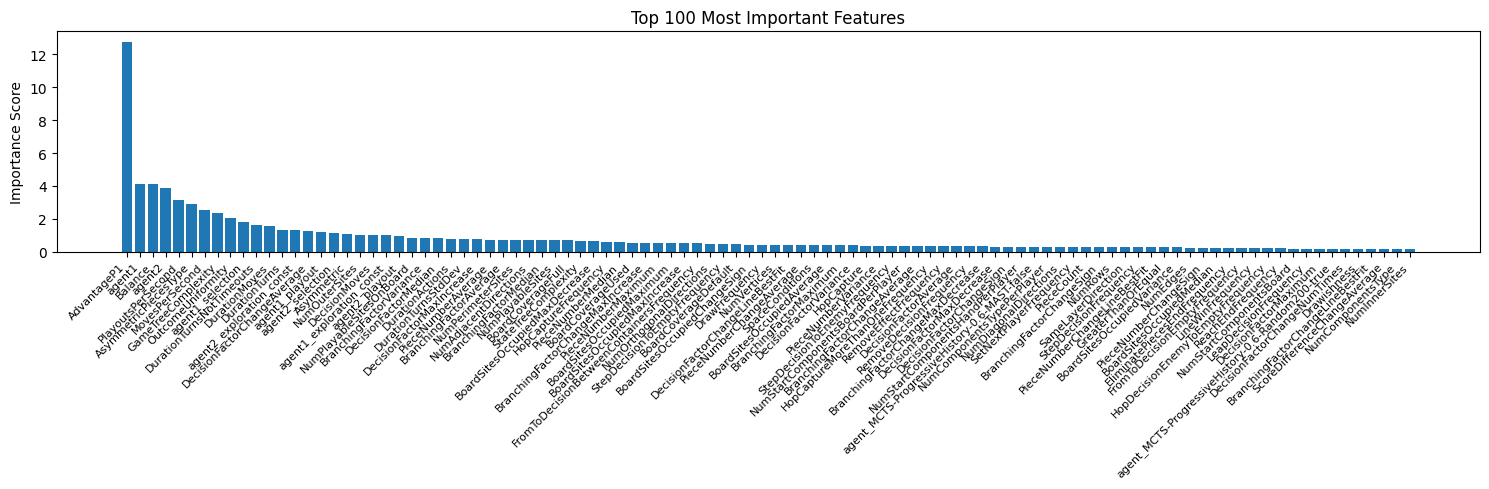

Fold 4 - RMSE: 0.4386520337737946
Fold 5


0:	learn: 0.6165231	test: 0.5440383	best: 0.5440383 (0)	total: 87.3ms	remaining: 4m 21s


50:	learn: 0.3955280	test: 0.4461723	best: 0.4461723 (50)	total: 5.22s	remaining: 5m 1s


100:	learn: 0.3547171	test: 0.4260909	best: 0.4260909 (100)	total: 10.6s	remaining: 5m 5s


150:	learn: 0.3313776	test: 0.4178006	best: 0.4178006 (150)	total: 16s	remaining: 5m 2s


200:	learn: 0.3144240	test: 0.4132868	best: 0.4132868 (200)	total: 21.4s	remaining: 4m 57s


250:	learn: 0.3023567	test: 0.4103624	best: 0.4103624 (250)	total: 27.2s	remaining: 4m 57s


300:	learn: 0.2925884	test: 0.4090338	best: 0.4090338 (300)	total: 32.5s	remaining: 4m 51s


350:	learn: 0.2844029	test: 0.4072430	best: 0.4072430 (350)	total: 38s	remaining: 4m 46s


400:	learn: 0.2771200	test: 0.4064658	best: 0.4064215 (393)	total: 43.4s	remaining: 4m 41s


450:	learn: 0.2709300	test: 0.4057681	best: 0.4057127 (448)	total: 48.8s	remaining: 4m 35s


500:	learn: 0.2650640	test: 0.4047750	best: 0.4047344 (497)	total: 54.2s	remaining: 4m 30s


550:	learn: 0.2601967	test: 0.4043202	best: 0.4042996 (546)	total: 59.7s	remaining: 4m 25s


600:	learn: 0.2553878	test: 0.4034253	best: 0.4034059 (598)	total: 1m 5s	remaining: 4m 20s


650:	learn: 0.2510365	test: 0.4032403	best: 0.4032183 (649)	total: 1m 10s	remaining: 4m 14s


700:	learn: 0.2474288	test: 0.4029047	best: 0.4029045 (699)	total: 1m 16s	remaining: 4m 9s


750:	learn: 0.2438939	test: 0.4027706	best: 0.4026935 (728)	total: 1m 21s	remaining: 4m 4s


800:	learn: 0.2406195	test: 0.4023272	best: 0.4023264 (798)	total: 1m 27s	remaining: 3m 59s


850:	learn: 0.2372259	test: 0.4021819	best: 0.4021240 (832)	total: 1m 32s	remaining: 3m 53s


900:	learn: 0.2342557	test: 0.4020240	best: 0.4020094 (885)	total: 1m 38s	remaining: 3m 48s


950:	learn: 0.2311314	test: 0.4019389	best: 0.4019077 (949)	total: 1m 43s	remaining: 3m 43s


1000:	learn: 0.2283849	test: 0.4016936	best: 0.4016589 (991)	total: 1m 49s	remaining: 3m 38s


1050:	learn: 0.2257773	test: 0.4016955	best: 0.4016589 (991)	total: 1m 54s	remaining: 3m 32s


1100:	learn: 0.2234727	test: 0.4014062	best: 0.4014027 (1097)	total: 2m	remaining: 3m 27s


1150:	learn: 0.2209435	test: 0.4012592	best: 0.4012425 (1133)	total: 2m 5s	remaining: 3m 21s


1200:	learn: 0.2189893	test: 0.4010833	best: 0.4010783 (1198)	total: 2m 11s	remaining: 3m 16s


1250:	learn: 0.2168478	test: 0.4009174	best: 0.4008954 (1238)	total: 2m 16s	remaining: 3m 11s


1300:	learn: 0.2148491	test: 0.4009461	best: 0.4008644 (1293)	total: 2m 22s	remaining: 3m 5s


1350:	learn: 0.2129373	test: 0.4009158	best: 0.4008469 (1343)	total: 2m 27s	remaining: 3m


1400:	learn: 0.2108728	test: 0.4010464	best: 0.4008469 (1343)	total: 2m 33s	remaining: 2m 55s


1450:	learn: 0.2089551	test: 0.4009570	best: 0.4008469 (1343)	total: 2m 39s	remaining: 2m 49s


1500:	learn: 0.2070632	test: 0.4009371	best: 0.4008469 (1343)	total: 2m 44s	remaining: 2m 44s


1550:	learn: 0.2050616	test: 0.4009406	best: 0.4008469 (1343)	total: 2m 50s	remaining: 2m 38s


1600:	learn: 0.2032600	test: 0.4008558	best: 0.4008419 (1598)	total: 2m 55s	remaining: 2m 33s


1650:	learn: 0.2017079	test: 0.4008446	best: 0.4008092 (1639)	total: 3m 1s	remaining: 2m 28s


1700:	learn: 0.1999971	test: 0.4006722	best: 0.4006624 (1699)	total: 3m 6s	remaining: 2m 22s


1750:	learn: 0.1982843	test: 0.4006465	best: 0.4006185 (1718)	total: 3m 12s	remaining: 2m 17s


1800:	learn: 0.1967377	test: 0.4006340	best: 0.4005742 (1789)	total: 3m 17s	remaining: 2m 11s


1850:	learn: 0.1952103	test: 0.4005948	best: 0.4005742 (1789)	total: 3m 23s	remaining: 2m 6s


1900:	learn: 0.1937778	test: 0.4005695	best: 0.4005537 (1863)	total: 3m 28s	remaining: 2m


1950:	learn: 0.1922837	test: 0.4004611	best: 0.4004583 (1947)	total: 3m 34s	remaining: 1m 55s


2000:	learn: 0.1906662	test: 0.4004014	best: 0.4003880 (1987)	total: 3m 39s	remaining: 1m 49s


2050:	learn: 0.1892721	test: 0.4004499	best: 0.4003880 (1987)	total: 3m 45s	remaining: 1m 44s


2100:	learn: 0.1878985	test: 0.4003909	best: 0.4003790 (2078)	total: 3m 50s	remaining: 1m 38s


2150:	learn: 0.1866653	test: 0.4003809	best: 0.4003610 (2127)	total: 3m 56s	remaining: 1m 33s


2200:	learn: 0.1852810	test: 0.4003780	best: 0.4003524 (2163)	total: 4m 1s	remaining: 1m 27s


2250:	learn: 0.1839794	test: 0.4004989	best: 0.4003524 (2163)	total: 4m 7s	remaining: 1m 22s


2300:	learn: 0.1827345	test: 0.4004960	best: 0.4003524 (2163)	total: 4m 12s	remaining: 1m 16s


2350:	learn: 0.1814867	test: 0.4005324	best: 0.4003524 (2163)	total: 4m 18s	remaining: 1m 11s


2400:	learn: 0.1801935	test: 0.4005497	best: 0.4003524 (2163)	total: 4m 23s	remaining: 1m 5s


2450:	learn: 0.1789340	test: 0.4005442	best: 0.4003524 (2163)	total: 4m 28s	remaining: 1m


2500:	learn: 0.1777063	test: 0.4005776	best: 0.4003524 (2163)	total: 4m 34s	remaining: 54.8s


2550:	learn: 0.1765185	test: 0.4005491	best: 0.4003524 (2163)	total: 4m 40s	remaining: 49.3s


2600:	learn: 0.1754249	test: 0.4005630	best: 0.4003524 (2163)	total: 4m 45s	remaining: 43.8s


2650:	learn: 0.1742444	test: 0.4005694	best: 0.4003524 (2163)	total: 4m 51s	remaining: 38.3s


2700:	learn: 0.1730614	test: 0.4005910	best: 0.4003524 (2163)	total: 4m 56s	remaining: 32.8s


2750:	learn: 0.1718640	test: 0.4006222	best: 0.4003524 (2163)	total: 5m 2s	remaining: 27.3s


2800:	learn: 0.1707172	test: 0.4005742	best: 0.4003524 (2163)	total: 5m 7s	remaining: 21.9s


2850:	learn: 0.1695711	test: 0.4005745	best: 0.4003524 (2163)	total: 5m 13s	remaining: 16.4s


2900:	learn: 0.1683871	test: 0.4005917	best: 0.4003524 (2163)	total: 5m 18s	remaining: 10.9s


2950:	learn: 0.1673268	test: 0.4005365	best: 0.4003524 (2163)	total: 5m 23s	remaining: 5.38s


2999:	learn: 0.1661772	test: 0.4004810	best: 0.4003524 (2163)	total: 5m 29s	remaining: 0us

bestTest = 0.400352431
bestIteration = 2163

Shrink model to first 2164 iterations.


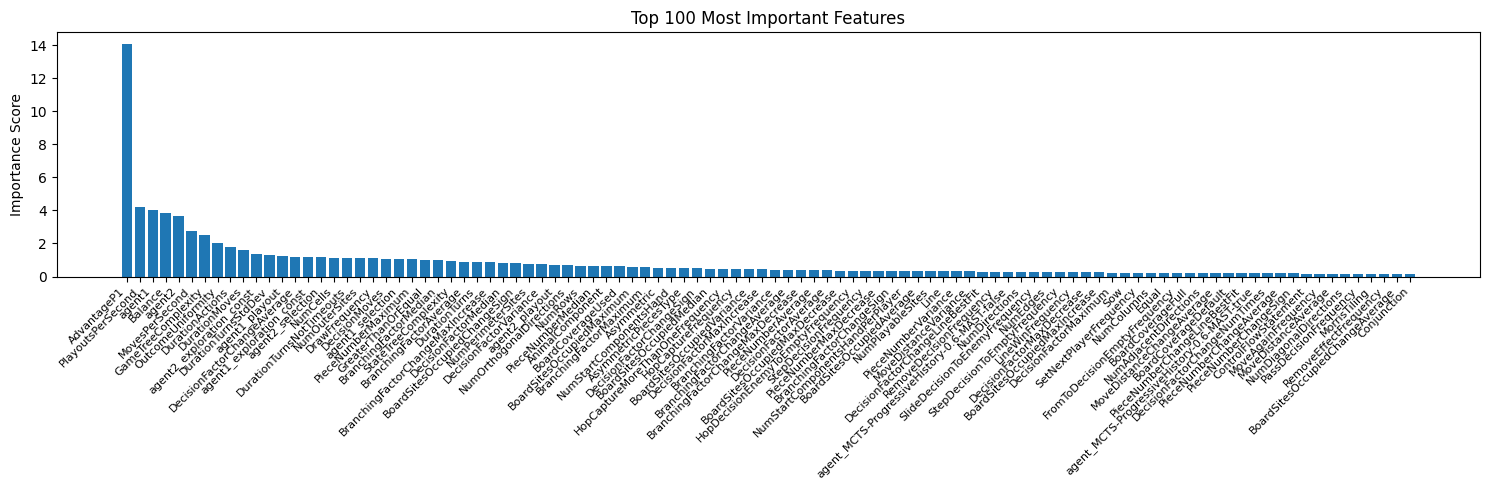

Fold 5 - RMSE: 0.39993863129119733
List of oof scores: [0.4198725737074144, 0.44687447495424704, 0.42664369277439135, 0.4386520337737946, 0.39993863129119733]
Average oof score: 0.4263962813002089


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6160610	test: 0.5321491	best: 0.5321491 (0)	total: 90.3ms	remaining: 4m 30s


50:	learn: 0.3910152	test: 0.4513902	best: 0.4513902 (50)	total: 5.22s	remaining: 5m 2s


100:	learn: 0.3517771	test: 0.4378011	best: 0.4378011 (100)	total: 10.6s	remaining: 5m 4s


150:	learn: 0.3269091	test: 0.4298849	best: 0.4298849 (150)	total: 16s	remaining: 5m 1s


200:	learn: 0.3113623	test: 0.4264687	best: 0.4264687 (200)	total: 21.3s	remaining: 4m 57s


250:	learn: 0.2991691	test: 0.4241040	best: 0.4241040 (250)	total: 26.7s	remaining: 4m 52s


300:	learn: 0.2890751	test: 0.4215187	best: 0.4215187 (300)	total: 32.1s	remaining: 4m 47s


350:	learn: 0.2810070	test: 0.4204993	best: 0.4203672 (346)	total: 37.5s	remaining: 4m 43s


400:	learn: 0.2740408	test: 0.4196652	best: 0.4196652 (400)	total: 42.9s	remaining: 4m 38s


450:	learn: 0.2682906	test: 0.4188958	best: 0.4188958 (450)	total: 48.4s	remaining: 4m 33s


500:	learn: 0.2625088	test: 0.4176265	best: 0.4176265 (500)	total: 53.8s	remaining: 4m 28s


550:	learn: 0.2569603	test: 0.4162629	best: 0.4162629 (550)	total: 59.2s	remaining: 4m 23s


600:	learn: 0.2521457	test: 0.4159023	best: 0.4158971 (599)	total: 1m 4s	remaining: 4m 18s


650:	learn: 0.2477941	test: 0.4153905	best: 0.4153905 (650)	total: 1m 10s	remaining: 4m 13s


700:	learn: 0.2435744	test: 0.4150808	best: 0.4150451 (687)	total: 1m 15s	remaining: 4m 7s


750:	learn: 0.2399208	test: 0.4148975	best: 0.4147369 (734)	total: 1m 20s	remaining: 4m 2s


800:	learn: 0.2365815	test: 0.4147716	best: 0.4147091 (781)	total: 1m 26s	remaining: 3m 57s


850:	learn: 0.2331975	test: 0.4143213	best: 0.4143213 (850)	total: 1m 31s	remaining: 3m 52s


900:	learn: 0.2300939	test: 0.4143344	best: 0.4142609 (893)	total: 1m 37s	remaining: 3m 47s


950:	learn: 0.2272427	test: 0.4143319	best: 0.4142609 (893)	total: 1m 42s	remaining: 3m 41s


1000:	learn: 0.2246063	test: 0.4139540	best: 0.4139415 (999)	total: 1m 48s	remaining: 3m 36s


1050:	learn: 0.2220157	test: 0.4136781	best: 0.4136768 (1048)	total: 1m 53s	remaining: 3m 30s


1100:	learn: 0.2194520	test: 0.4136598	best: 0.4135664 (1086)	total: 1m 59s	remaining: 3m 25s


1150:	learn: 0.2169696	test: 0.4135450	best: 0.4135276 (1140)	total: 2m 4s	remaining: 3m 20s


1200:	learn: 0.2147158	test: 0.4133158	best: 0.4133104 (1194)	total: 2m 10s	remaining: 3m 15s


1250:	learn: 0.2126331	test: 0.4133147	best: 0.4132505 (1218)	total: 2m 15s	remaining: 3m 9s


1300:	learn: 0.2105687	test: 0.4134138	best: 0.4132505 (1218)	total: 2m 21s	remaining: 3m 4s


1350:	learn: 0.2084677	test: 0.4133743	best: 0.4132505 (1218)	total: 2m 26s	remaining: 2m 59s


1400:	learn: 0.2066516	test: 0.4132474	best: 0.4132474 (1400)	total: 2m 32s	remaining: 2m 53s


1450:	learn: 0.2046683	test: 0.4131116	best: 0.4130988 (1448)	total: 2m 37s	remaining: 2m 48s


1500:	learn: 0.2029831	test: 0.4130264	best: 0.4130003 (1481)	total: 2m 43s	remaining: 2m 43s


1550:	learn: 0.2011897	test: 0.4129910	best: 0.4129872 (1549)	total: 2m 48s	remaining: 2m 37s


1600:	learn: 0.1995658	test: 0.4129717	best: 0.4129046 (1568)	total: 2m 54s	remaining: 2m 32s


1650:	learn: 0.1978022	test: 0.4130152	best: 0.4129046 (1568)	total: 2m 59s	remaining: 2m 26s


1700:	learn: 0.1961929	test: 0.4129796	best: 0.4129046 (1568)	total: 3m 5s	remaining: 2m 21s


1750:	learn: 0.1946492	test: 0.4129162	best: 0.4129046 (1568)	total: 3m 10s	remaining: 2m 16s


1800:	learn: 0.1929585	test: 0.4127724	best: 0.4127623 (1797)	total: 3m 16s	remaining: 2m 10s


1850:	learn: 0.1914012	test: 0.4127373	best: 0.4127056 (1843)	total: 3m 21s	remaining: 2m 5s


1900:	learn: 0.1900152	test: 0.4127025	best: 0.4126637 (1887)	total: 3m 27s	remaining: 1m 59s


1950:	learn: 0.1885092	test: 0.4125955	best: 0.4125688 (1945)	total: 3m 32s	remaining: 1m 54s


2000:	learn: 0.1871219	test: 0.4125439	best: 0.4125389 (1999)	total: 3m 38s	remaining: 1m 48s


2050:	learn: 0.1858256	test: 0.4124720	best: 0.4124666 (2044)	total: 3m 43s	remaining: 1m 43s


2100:	learn: 0.1844149	test: 0.4125648	best: 0.4124666 (2044)	total: 3m 49s	remaining: 1m 38s


2150:	learn: 0.1829698	test: 0.4125900	best: 0.4124666 (2044)	total: 3m 54s	remaining: 1m 32s


2200:	learn: 0.1816236	test: 0.4124987	best: 0.4124666 (2044)	total: 4m	remaining: 1m 27s


2250:	learn: 0.1802063	test: 0.4124495	best: 0.4124329 (2235)	total: 4m 5s	remaining: 1m 21s


2300:	learn: 0.1788214	test: 0.4125000	best: 0.4124329 (2235)	total: 4m 11s	remaining: 1m 16s


2350:	learn: 0.1775697	test: 0.4124801	best: 0.4124329 (2235)	total: 4m 16s	remaining: 1m 10s


2400:	learn: 0.1762352	test: 0.4124660	best: 0.4124329 (2235)	total: 4m 22s	remaining: 1m 5s


2450:	learn: 0.1750912	test: 0.4124004	best: 0.4123984 (2448)	total: 4m 27s	remaining: 59.9s


2500:	learn: 0.1737894	test: 0.4124313	best: 0.4123984 (2448)	total: 4m 32s	remaining: 54.5s


2550:	learn: 0.1727215	test: 0.4124239	best: 0.4123984 (2448)	total: 4m 38s	remaining: 49s


2600:	learn: 0.1715230	test: 0.4124222	best: 0.4123984 (2448)	total: 4m 43s	remaining: 43.6s


2650:	learn: 0.1704082	test: 0.4124044	best: 0.4123726 (2629)	total: 4m 49s	remaining: 38.1s


2700:	learn: 0.1692799	test: 0.4124234	best: 0.4123726 (2629)	total: 4m 54s	remaining: 32.6s


2750:	learn: 0.1682224	test: 0.4124259	best: 0.4123726 (2629)	total: 5m	remaining: 27.2s


2800:	learn: 0.1671878	test: 0.4124150	best: 0.4123726 (2629)	total: 5m 6s	remaining: 21.7s


2850:	learn: 0.1661032	test: 0.4124326	best: 0.4123726 (2629)	total: 5m 11s	remaining: 16.3s


2900:	learn: 0.1649863	test: 0.4124710	best: 0.4123726 (2629)	total: 5m 16s	remaining: 10.8s


2950:	learn: 0.1639072	test: 0.4125240	best: 0.4123726 (2629)	total: 5m 22s	remaining: 5.35s


2999:	learn: 0.1628542	test: 0.4125288	best: 0.4123726 (2629)	total: 5m 27s	remaining: 0us

bestTest = 0.4123725588
bestIteration = 2629

Shrink model to first 2630 iterations.


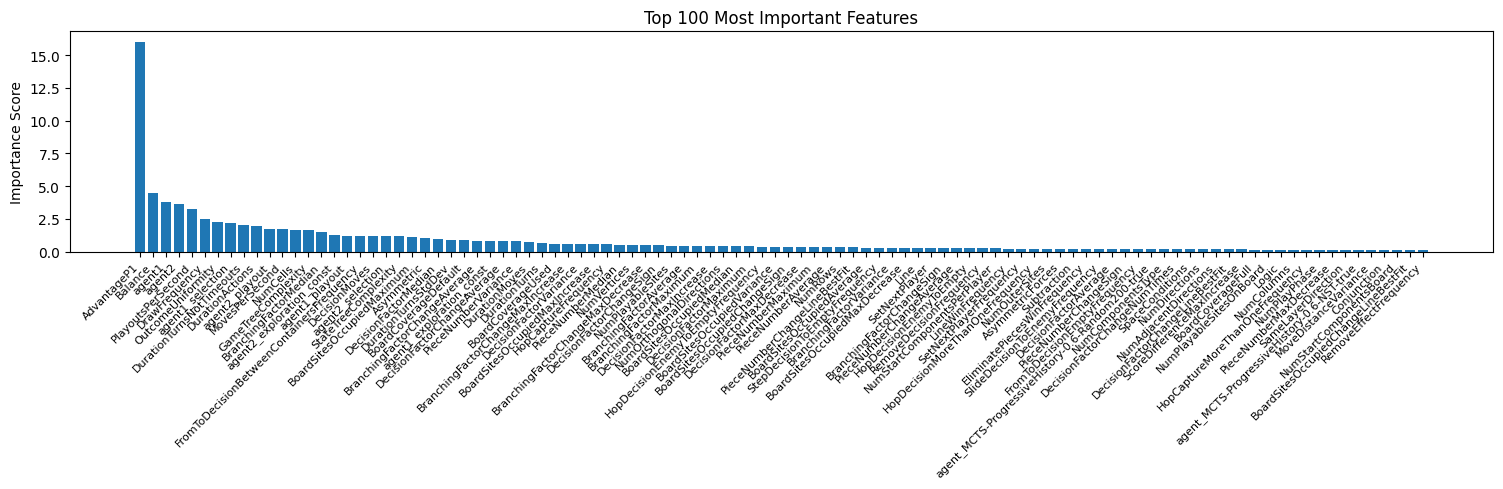

Fold 1 - RMSE: 0.4120705515526439
Fold 2


0:	learn: 0.6141486	test: 0.5383354	best: 0.5383354 (0)	total: 95.3ms	remaining: 4m 45s


50:	learn: 0.3882938	test: 0.4243620	best: 0.4243620 (50)	total: 5.31s	remaining: 5m 7s


100:	learn: 0.3491767	test: 0.4111941	best: 0.4111472 (99)	total: 10.9s	remaining: 5m 13s


150:	learn: 0.3246232	test: 0.4053992	best: 0.4052922 (149)	total: 16.2s	remaining: 5m 6s


200:	learn: 0.3089493	test: 0.4028977	best: 0.4028977 (200)	total: 21.7s	remaining: 5m 1s


250:	learn: 0.2966457	test: 0.4014309	best: 0.4014309 (250)	total: 27.1s	remaining: 4m 56s


300:	learn: 0.2874579	test: 0.4001217	best: 0.4000521 (292)	total: 32.6s	remaining: 4m 52s


350:	learn: 0.2792758	test: 0.3989008	best: 0.3989008 (350)	total: 38.1s	remaining: 4m 47s


400:	learn: 0.2722237	test: 0.3983803	best: 0.3982833 (395)	total: 43.6s	remaining: 4m 42s


450:	learn: 0.2659787	test: 0.3981019	best: 0.3980950 (430)	total: 49s	remaining: 4m 36s


500:	learn: 0.2601659	test: 0.3980726	best: 0.3979770 (492)	total: 54.5s	remaining: 4m 31s


550:	learn: 0.2551748	test: 0.3981703	best: 0.3979770 (492)	total: 59.9s	remaining: 4m 26s


600:	learn: 0.2507947	test: 0.3979411	best: 0.3978452 (579)	total: 1m 5s	remaining: 4m 21s


650:	learn: 0.2466271	test: 0.3978523	best: 0.3976912 (638)	total: 1m 11s	remaining: 4m 16s


700:	learn: 0.2425601	test: 0.3977697	best: 0.3976912 (638)	total: 1m 16s	remaining: 4m 11s


750:	learn: 0.2391457	test: 0.3973762	best: 0.3973762 (750)	total: 1m 22s	remaining: 4m 5s


800:	learn: 0.2358213	test: 0.3972736	best: 0.3971830 (786)	total: 1m 27s	remaining: 4m


850:	learn: 0.2324244	test: 0.3972659	best: 0.3971830 (786)	total: 1m 33s	remaining: 3m 54s


900:	learn: 0.2295745	test: 0.3972816	best: 0.3971830 (786)	total: 1m 38s	remaining: 3m 49s


950:	learn: 0.2269105	test: 0.3972657	best: 0.3971654 (923)	total: 1m 44s	remaining: 3m 44s


1000:	learn: 0.2242010	test: 0.3972606	best: 0.3971654 (923)	total: 1m 49s	remaining: 3m 38s


1050:	learn: 0.2217244	test: 0.3972849	best: 0.3971654 (923)	total: 1m 55s	remaining: 3m 33s


1100:	learn: 0.2193976	test: 0.3972981	best: 0.3971654 (923)	total: 2m	remaining: 3m 27s


1150:	learn: 0.2169397	test: 0.3971539	best: 0.3971433 (1145)	total: 2m 6s	remaining: 3m 22s


1200:	learn: 0.2148192	test: 0.3970659	best: 0.3970639 (1199)	total: 2m 11s	remaining: 3m 17s


1250:	learn: 0.2126384	test: 0.3970554	best: 0.3970242 (1245)	total: 2m 17s	remaining: 3m 11s


1300:	learn: 0.2107106	test: 0.3970524	best: 0.3969758 (1281)	total: 2m 22s	remaining: 3m 6s


1350:	learn: 0.2086875	test: 0.3970490	best: 0.3969758 (1281)	total: 2m 28s	remaining: 3m 1s


1400:	learn: 0.2067022	test: 0.3970569	best: 0.3969685 (1389)	total: 2m 33s	remaining: 2m 55s


1450:	learn: 0.2050238	test: 0.3970419	best: 0.3969685 (1389)	total: 2m 39s	remaining: 2m 50s


1500:	learn: 0.2031382	test: 0.3970109	best: 0.3969632 (1487)	total: 2m 44s	remaining: 2m 44s


1550:	learn: 0.2013286	test: 0.3970397	best: 0.3969594 (1525)	total: 2m 50s	remaining: 2m 39s


1600:	learn: 0.1997304	test: 0.3970617	best: 0.3969594 (1525)	total: 2m 56s	remaining: 2m 33s


1650:	learn: 0.1980812	test: 0.3971505	best: 0.3969594 (1525)	total: 3m 1s	remaining: 2m 28s


1700:	learn: 0.1965954	test: 0.3972032	best: 0.3969594 (1525)	total: 3m 7s	remaining: 2m 22s


1750:	learn: 0.1949784	test: 0.3971923	best: 0.3969594 (1525)	total: 3m 12s	remaining: 2m 17s


1800:	learn: 0.1934498	test: 0.3972569	best: 0.3969594 (1525)	total: 3m 18s	remaining: 2m 12s


1850:	learn: 0.1919487	test: 0.3973557	best: 0.3969594 (1525)	total: 3m 23s	remaining: 2m 6s


1900:	learn: 0.1903926	test: 0.3975238	best: 0.3969594 (1525)	total: 3m 29s	remaining: 2m 1s


1950:	learn: 0.1889223	test: 0.3975886	best: 0.3969594 (1525)	total: 3m 34s	remaining: 1m 55s


2000:	learn: 0.1874510	test: 0.3976287	best: 0.3969594 (1525)	total: 3m 40s	remaining: 1m 50s


2050:	learn: 0.1861147	test: 0.3976590	best: 0.3969594 (1525)	total: 3m 46s	remaining: 1m 44s


2100:	learn: 0.1846871	test: 0.3976942	best: 0.3969594 (1525)	total: 3m 51s	remaining: 1m 39s


2150:	learn: 0.1833498	test: 0.3977595	best: 0.3969594 (1525)	total: 3m 57s	remaining: 1m 33s


2200:	learn: 0.1820708	test: 0.3978164	best: 0.3969594 (1525)	total: 4m 2s	remaining: 1m 28s


2250:	learn: 0.1807614	test: 0.3978527	best: 0.3969594 (1525)	total: 4m 8s	remaining: 1m 22s


2300:	learn: 0.1796129	test: 0.3978962	best: 0.3969594 (1525)	total: 4m 13s	remaining: 1m 17s


2350:	learn: 0.1784288	test: 0.3979336	best: 0.3969594 (1525)	total: 4m 19s	remaining: 1m 11s


2400:	learn: 0.1772421	test: 0.3980439	best: 0.3969594 (1525)	total: 4m 25s	remaining: 1m 6s


2450:	learn: 0.1760001	test: 0.3980277	best: 0.3969594 (1525)	total: 4m 30s	remaining: 1m


2500:	learn: 0.1748463	test: 0.3980491	best: 0.3969594 (1525)	total: 4m 36s	remaining: 55.1s


2550:	learn: 0.1736488	test: 0.3980642	best: 0.3969594 (1525)	total: 4m 41s	remaining: 49.6s


2600:	learn: 0.1723995	test: 0.3980352	best: 0.3969594 (1525)	total: 4m 47s	remaining: 44.1s


2650:	learn: 0.1711656	test: 0.3980940	best: 0.3969594 (1525)	total: 4m 52s	remaining: 38.5s


2700:	learn: 0.1700061	test: 0.3981125	best: 0.3969594 (1525)	total: 4m 58s	remaining: 33s


2750:	learn: 0.1688125	test: 0.3980650	best: 0.3969594 (1525)	total: 5m 3s	remaining: 27.5s


2800:	learn: 0.1675575	test: 0.3980662	best: 0.3969594 (1525)	total: 5m 9s	remaining: 22s


2850:	learn: 0.1664899	test: 0.3980709	best: 0.3969594 (1525)	total: 5m 14s	remaining: 16.4s


2900:	learn: 0.1653939	test: 0.3980870	best: 0.3969594 (1525)	total: 5m 20s	remaining: 10.9s


2950:	learn: 0.1642090	test: 0.3981288	best: 0.3969594 (1525)	total: 5m 25s	remaining: 5.41s


2999:	learn: 0.1632335	test: 0.3982139	best: 0.3969594 (1525)	total: 5m 31s	remaining: 0us

bestTest = 0.396959431
bestIteration = 1525

Shrink model to first 1526 iterations.


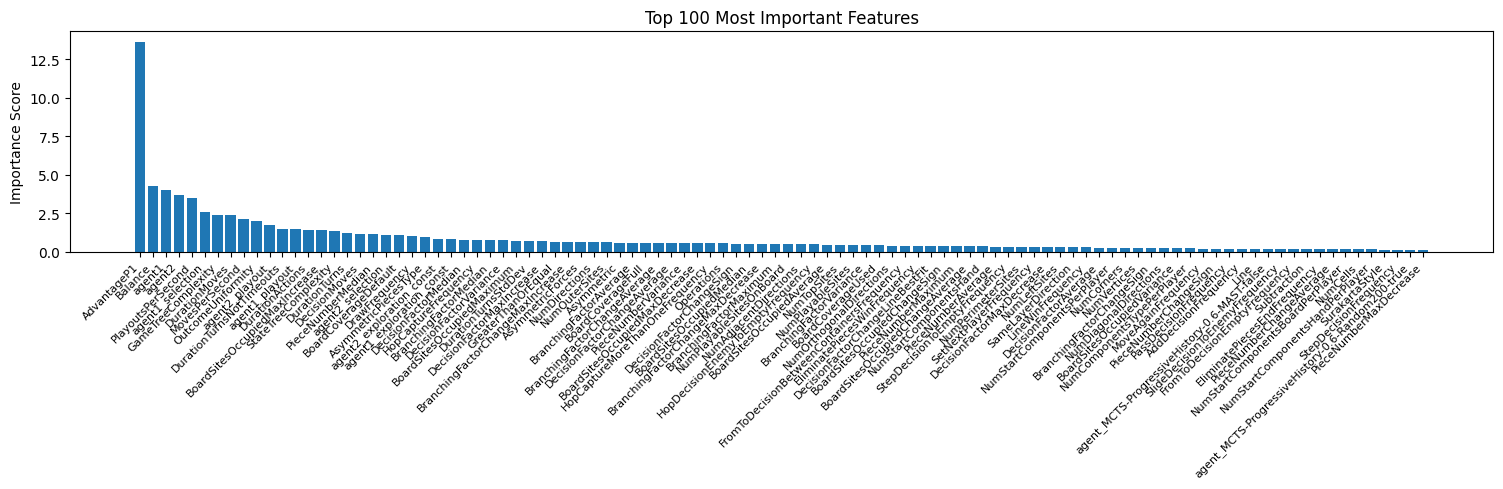

Fold 2 - RMSE: 0.39659996358696037
Fold 3


0:	learn: 0.6000324	test: 0.6076641	best: 0.6076641 (0)	total: 99.5ms	remaining: 4m 58s


50:	learn: 0.3834092	test: 0.4794720	best: 0.4794720 (50)	total: 5.3s	remaining: 5m 6s


100:	learn: 0.3455357	test: 0.4575865	best: 0.4575865 (100)	total: 10.9s	remaining: 5m 14s


150:	learn: 0.3217221	test: 0.4476177	best: 0.4476177 (150)	total: 16.4s	remaining: 5m 9s


200:	learn: 0.3064877	test: 0.4432885	best: 0.4432818 (199)	total: 21.9s	remaining: 5m 4s


250:	learn: 0.2947552	test: 0.4406402	best: 0.4406402 (250)	total: 27.3s	remaining: 4m 59s


300:	learn: 0.2855987	test: 0.4377820	best: 0.4377820 (300)	total: 32.7s	remaining: 4m 53s


350:	learn: 0.2773527	test: 0.4367267	best: 0.4367267 (350)	total: 38.2s	remaining: 4m 48s


400:	learn: 0.2704601	test: 0.4354190	best: 0.4354190 (400)	total: 43.7s	remaining: 4m 43s


450:	learn: 0.2643414	test: 0.4344451	best: 0.4344451 (450)	total: 49.2s	remaining: 4m 38s


500:	learn: 0.2591062	test: 0.4339399	best: 0.4339185 (498)	total: 54.7s	remaining: 4m 32s


550:	learn: 0.2540491	test: 0.4329787	best: 0.4329675 (547)	total: 1m	remaining: 4m 27s


600:	learn: 0.2494157	test: 0.4321812	best: 0.4321812 (600)	total: 1m 5s	remaining: 4m 22s


650:	learn: 0.2453992	test: 0.4313957	best: 0.4313957 (650)	total: 1m 11s	remaining: 4m 16s


700:	learn: 0.2415003	test: 0.4309407	best: 0.4309407 (700)	total: 1m 16s	remaining: 4m 11s


750:	learn: 0.2377947	test: 0.4303221	best: 0.4303221 (750)	total: 1m 22s	remaining: 4m 6s


800:	learn: 0.2343691	test: 0.4297612	best: 0.4297221 (796)	total: 1m 27s	remaining: 4m 1s


850:	learn: 0.2312211	test: 0.4294920	best: 0.4294917 (849)	total: 1m 33s	remaining: 3m 55s


900:	learn: 0.2282040	test: 0.4288649	best: 0.4288649 (900)	total: 1m 38s	remaining: 3m 50s


950:	learn: 0.2254678	test: 0.4287381	best: 0.4286511 (940)	total: 1m 44s	remaining: 3m 45s


1000:	learn: 0.2231575	test: 0.4286075	best: 0.4285853 (989)	total: 1m 50s	remaining: 3m 40s


1050:	learn: 0.2207078	test: 0.4284068	best: 0.4284068 (1050)	total: 1m 55s	remaining: 3m 34s


1100:	learn: 0.2182669	test: 0.4281786	best: 0.4281732 (1099)	total: 2m 1s	remaining: 3m 29s


1150:	learn: 0.2160901	test: 0.4279891	best: 0.4279865 (1149)	total: 2m 6s	remaining: 3m 23s


1200:	learn: 0.2138904	test: 0.4277685	best: 0.4277208 (1190)	total: 2m 12s	remaining: 3m 18s


1250:	learn: 0.2121062	test: 0.4276133	best: 0.4276120 (1246)	total: 2m 18s	remaining: 3m 13s


1300:	learn: 0.2101302	test: 0.4275119	best: 0.4275032 (1298)	total: 2m 23s	remaining: 3m 7s


1350:	learn: 0.2082145	test: 0.4276006	best: 0.4274844 (1313)	total: 2m 29s	remaining: 3m 2s


1400:	learn: 0.2064216	test: 0.4274605	best: 0.4274387 (1397)	total: 2m 34s	remaining: 2m 56s


1450:	learn: 0.2046556	test: 0.4273363	best: 0.4273254 (1445)	total: 2m 40s	remaining: 2m 51s


1500:	learn: 0.2029350	test: 0.4271423	best: 0.4271423 (1500)	total: 2m 46s	remaining: 2m 46s


1550:	learn: 0.2012724	test: 0.4270416	best: 0.4270371 (1549)	total: 2m 51s	remaining: 2m 40s


1600:	learn: 0.1995366	test: 0.4270297	best: 0.4269987 (1573)	total: 2m 57s	remaining: 2m 35s


1650:	learn: 0.1979491	test: 0.4269172	best: 0.4269172 (1650)	total: 3m 3s	remaining: 2m 29s


1700:	learn: 0.1962954	test: 0.4268195	best: 0.4268028 (1697)	total: 3m 9s	remaining: 2m 24s


1750:	learn: 0.1948139	test: 0.4267757	best: 0.4267485 (1720)	total: 3m 14s	remaining: 2m 18s


1800:	learn: 0.1933141	test: 0.4266887	best: 0.4266864 (1793)	total: 3m 20s	remaining: 2m 13s


1850:	learn: 0.1917260	test: 0.4266824	best: 0.4266797 (1849)	total: 3m 25s	remaining: 2m 7s


1900:	learn: 0.1903907	test: 0.4265689	best: 0.4265689 (1900)	total: 3m 31s	remaining: 2m 2s


1950:	learn: 0.1888778	test: 0.4264967	best: 0.4264960 (1946)	total: 3m 36s	remaining: 1m 56s


2000:	learn: 0.1874606	test: 0.4264878	best: 0.4264690 (1994)	total: 3m 42s	remaining: 1m 51s


2050:	learn: 0.1860842	test: 0.4264690	best: 0.4264500 (2018)	total: 3m 48s	remaining: 1m 45s


2100:	learn: 0.1846759	test: 0.4264397	best: 0.4264291 (2097)	total: 3m 53s	remaining: 1m 40s


2150:	learn: 0.1834986	test: 0.4264529	best: 0.4264287 (2131)	total: 3m 59s	remaining: 1m 34s


2200:	learn: 0.1822231	test: 0.4263712	best: 0.4263648 (2199)	total: 4m 4s	remaining: 1m 28s


2250:	learn: 0.1808453	test: 0.4263028	best: 0.4262944 (2249)	total: 4m 10s	remaining: 1m 23s


2300:	learn: 0.1795579	test: 0.4262669	best: 0.4262527 (2292)	total: 4m 16s	remaining: 1m 17s


2350:	learn: 0.1783356	test: 0.4262719	best: 0.4262527 (2292)	total: 4m 21s	remaining: 1m 12s


2400:	learn: 0.1772189	test: 0.4262031	best: 0.4262031 (2400)	total: 4m 27s	remaining: 1m 6s


2450:	learn: 0.1759323	test: 0.4261583	best: 0.4261389 (2435)	total: 4m 32s	remaining: 1m 1s


2500:	learn: 0.1746741	test: 0.4261406	best: 0.4261213 (2485)	total: 4m 38s	remaining: 55.6s


2550:	learn: 0.1735904	test: 0.4260667	best: 0.4260667 (2550)	total: 4m 44s	remaining: 50s


2600:	learn: 0.1723841	test: 0.4260311	best: 0.4260197 (2595)	total: 4m 49s	remaining: 44.4s


2650:	learn: 0.1712317	test: 0.4260875	best: 0.4260197 (2595)	total: 4m 55s	remaining: 38.9s


2700:	learn: 0.1701337	test: 0.4261292	best: 0.4260197 (2595)	total: 5m	remaining: 33.3s


2750:	learn: 0.1689342	test: 0.4260905	best: 0.4260197 (2595)	total: 5m 6s	remaining: 27.7s


2800:	learn: 0.1677297	test: 0.4260649	best: 0.4260197 (2595)	total: 5m 11s	remaining: 22.1s


2850:	learn: 0.1665587	test: 0.4259958	best: 0.4259924 (2847)	total: 5m 17s	remaining: 16.6s


2900:	learn: 0.1655540	test: 0.4259500	best: 0.4259364 (2896)	total: 5m 22s	remaining: 11s


2950:	learn: 0.1645269	test: 0.4259258	best: 0.4259204 (2940)	total: 5m 28s	remaining: 5.45s


2999:	learn: 0.1636343	test: 0.4259725	best: 0.4259159 (2958)	total: 5m 33s	remaining: 0us

bestTest = 0.425915887
bestIteration = 2958

Shrink model to first 2959 iterations.


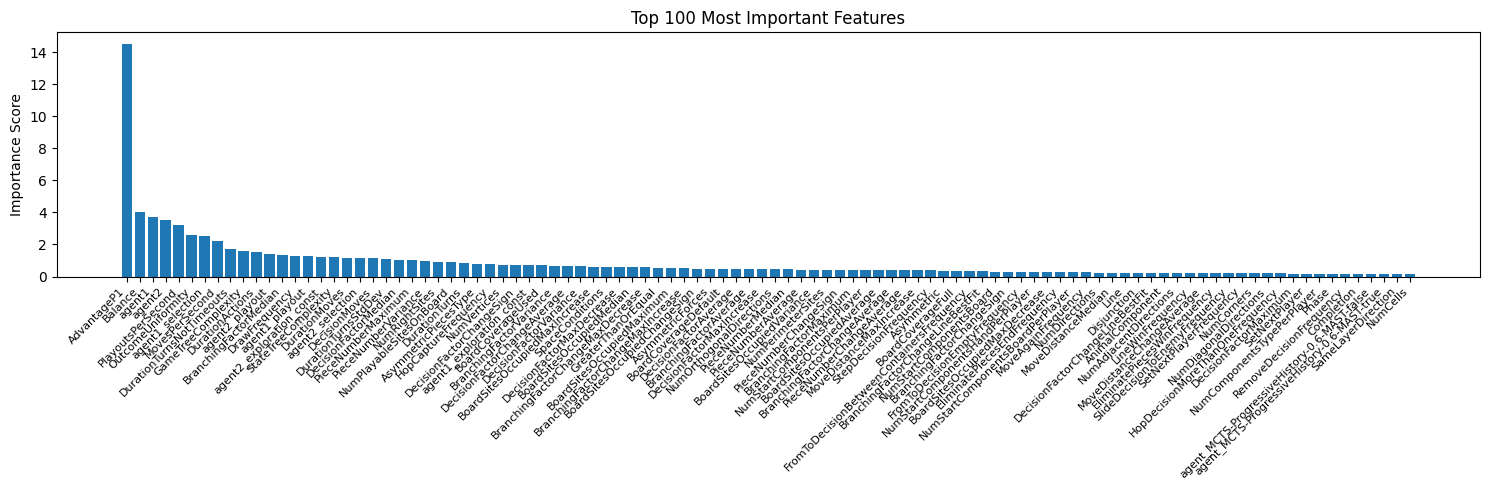

Fold 3 - RMSE: 0.42529769969824005
Fold 4


0:	learn: 0.6028823	test: 0.5976699	best: 0.5976699 (0)	total: 101ms	remaining: 5m 2s


50:	learn: 0.3915092	test: 0.4844368	best: 0.4844368 (50)	total: 5.08s	remaining: 4m 53s


100:	learn: 0.3507690	test: 0.4638661	best: 0.4638661 (100)	total: 10.8s	remaining: 5m 9s


150:	learn: 0.3274109	test: 0.4567639	best: 0.4567639 (150)	total: 16.3s	remaining: 5m 7s


200:	learn: 0.3129897	test: 0.4523025	best: 0.4523025 (200)	total: 21.8s	remaining: 5m 3s


250:	learn: 0.3011377	test: 0.4493807	best: 0.4493807 (250)	total: 27.3s	remaining: 4m 58s


300:	learn: 0.2913221	test: 0.4475546	best: 0.4475546 (300)	total: 32.9s	remaining: 4m 54s


350:	learn: 0.2833770	test: 0.4464842	best: 0.4463176 (345)	total: 38.5s	remaining: 4m 50s


400:	learn: 0.2763117	test: 0.4456266	best: 0.4456076 (396)	total: 44.2s	remaining: 4m 46s


450:	learn: 0.2694596	test: 0.4442238	best: 0.4442238 (450)	total: 49.8s	remaining: 4m 41s


500:	learn: 0.2641518	test: 0.4436870	best: 0.4435421 (493)	total: 55.3s	remaining: 4m 35s


550:	learn: 0.2592977	test: 0.4433042	best: 0.4433042 (550)	total: 1m	remaining: 4m 31s


600:	learn: 0.2546763	test: 0.4427693	best: 0.4427693 (600)	total: 1m 6s	remaining: 4m 25s


650:	learn: 0.2505472	test: 0.4421811	best: 0.4421581 (638)	total: 1m 12s	remaining: 4m 20s


700:	learn: 0.2468775	test: 0.4416064	best: 0.4416064 (700)	total: 1m 17s	remaining: 4m 14s


750:	learn: 0.2433752	test: 0.4413300	best: 0.4413114 (742)	total: 1m 23s	remaining: 4m 9s


800:	learn: 0.2400115	test: 0.4411721	best: 0.4411346 (788)	total: 1m 28s	remaining: 4m 3s


850:	learn: 0.2367495	test: 0.4407376	best: 0.4407376 (850)	total: 1m 34s	remaining: 3m 58s


900:	learn: 0.2337832	test: 0.4404729	best: 0.4404566 (896)	total: 1m 40s	remaining: 3m 53s


950:	learn: 0.2311875	test: 0.4404011	best: 0.4403870 (938)	total: 1m 45s	remaining: 3m 47s


1000:	learn: 0.2283635	test: 0.4402258	best: 0.4401857 (982)	total: 1m 51s	remaining: 3m 42s


1050:	learn: 0.2257917	test: 0.4398905	best: 0.4398905 (1050)	total: 1m 56s	remaining: 3m 36s


1100:	learn: 0.2236922	test: 0.4397448	best: 0.4396606 (1087)	total: 2m 2s	remaining: 3m 31s


1150:	learn: 0.2214871	test: 0.4394912	best: 0.4394843 (1141)	total: 2m 8s	remaining: 3m 26s


1200:	learn: 0.2194589	test: 0.4393418	best: 0.4393381 (1197)	total: 2m 13s	remaining: 3m 20s


1250:	learn: 0.2171705	test: 0.4393305	best: 0.4393302 (1232)	total: 2m 19s	remaining: 3m 15s


1300:	learn: 0.2150048	test: 0.4391810	best: 0.4391776 (1298)	total: 2m 25s	remaining: 3m 9s


1350:	learn: 0.2130679	test: 0.4391138	best: 0.4391138 (1350)	total: 2m 31s	remaining: 3m 4s


1400:	learn: 0.2112809	test: 0.4389190	best: 0.4389063 (1398)	total: 2m 36s	remaining: 2m 58s


1450:	learn: 0.2093847	test: 0.4388589	best: 0.4388589 (1450)	total: 2m 42s	remaining: 2m 53s


1500:	learn: 0.2076104	test: 0.4386624	best: 0.4386624 (1500)	total: 2m 48s	remaining: 2m 47s


1550:	learn: 0.2060230	test: 0.4385637	best: 0.4385509 (1546)	total: 2m 53s	remaining: 2m 42s


1600:	learn: 0.2042313	test: 0.4384936	best: 0.4384437 (1591)	total: 2m 59s	remaining: 2m 36s


1650:	learn: 0.2025745	test: 0.4383898	best: 0.4383384 (1647)	total: 3m 4s	remaining: 2m 31s


1700:	learn: 0.2009782	test: 0.4382761	best: 0.4382579 (1699)	total: 3m 10s	remaining: 2m 25s


1750:	learn: 0.1992847	test: 0.4381756	best: 0.4381754 (1749)	total: 3m 16s	remaining: 2m 19s


1800:	learn: 0.1979119	test: 0.4380652	best: 0.4380387 (1788)	total: 3m 21s	remaining: 2m 14s


1850:	learn: 0.1962624	test: 0.4380461	best: 0.4380387 (1788)	total: 3m 27s	remaining: 2m 8s


1900:	learn: 0.1946807	test: 0.4379810	best: 0.4379778 (1898)	total: 3m 33s	remaining: 2m 3s


1950:	learn: 0.1931605	test: 0.4378781	best: 0.4378781 (1950)	total: 3m 38s	remaining: 1m 57s


2000:	learn: 0.1916698	test: 0.4379294	best: 0.4378598 (1984)	total: 3m 44s	remaining: 1m 51s


2050:	learn: 0.1902525	test: 0.4378975	best: 0.4378580 (2030)	total: 3m 49s	remaining: 1m 46s


2100:	learn: 0.1888507	test: 0.4377933	best: 0.4377933 (2100)	total: 3m 55s	remaining: 1m 40s


2150:	learn: 0.1875545	test: 0.4377614	best: 0.4377290 (2141)	total: 4m 1s	remaining: 1m 35s


2200:	learn: 0.1860427	test: 0.4377914	best: 0.4377290 (2141)	total: 4m 6s	remaining: 1m 29s


2250:	learn: 0.1847071	test: 0.4377975	best: 0.4377290 (2141)	total: 4m 12s	remaining: 1m 24s


2300:	learn: 0.1835500	test: 0.4377773	best: 0.4377290 (2141)	total: 4m 18s	remaining: 1m 18s


2350:	learn: 0.1822735	test: 0.4377765	best: 0.4377290 (2141)	total: 4m 23s	remaining: 1m 12s


2400:	learn: 0.1810785	test: 0.4376944	best: 0.4376931 (2387)	total: 4m 29s	remaining: 1m 7s


2450:	learn: 0.1798728	test: 0.4376418	best: 0.4376418 (2450)	total: 4m 35s	remaining: 1m 1s


2500:	learn: 0.1787450	test: 0.4376352	best: 0.4376289 (2470)	total: 4m 40s	remaining: 56s


2550:	learn: 0.1775106	test: 0.4376773	best: 0.4375794 (2510)	total: 4m 46s	remaining: 50.4s


2600:	learn: 0.1762226	test: 0.4376271	best: 0.4375794 (2510)	total: 4m 51s	remaining: 44.8s


2650:	learn: 0.1749487	test: 0.4375497	best: 0.4375416 (2630)	total: 4m 57s	remaining: 39.2s


2700:	learn: 0.1737670	test: 0.4375120	best: 0.4375109 (2699)	total: 5m 3s	remaining: 33.5s


2750:	learn: 0.1727650	test: 0.4375242	best: 0.4374961 (2730)	total: 5m 8s	remaining: 27.9s


2800:	learn: 0.1716866	test: 0.4375736	best: 0.4374961 (2730)	total: 5m 14s	remaining: 22.3s


2850:	learn: 0.1705851	test: 0.4374948	best: 0.4374938 (2848)	total: 5m 19s	remaining: 16.7s


2900:	learn: 0.1696530	test: 0.4374747	best: 0.4374421 (2875)	total: 5m 25s	remaining: 11.1s


2950:	learn: 0.1686783	test: 0.4374320	best: 0.4374212 (2942)	total: 5m 31s	remaining: 5.5s


2999:	learn: 0.1676595	test: 0.4372677	best: 0.4372637 (2990)	total: 5m 36s	remaining: 0us

bestTest = 0.4372636894
bestIteration = 2990

Shrink model to first 2991 iterations.


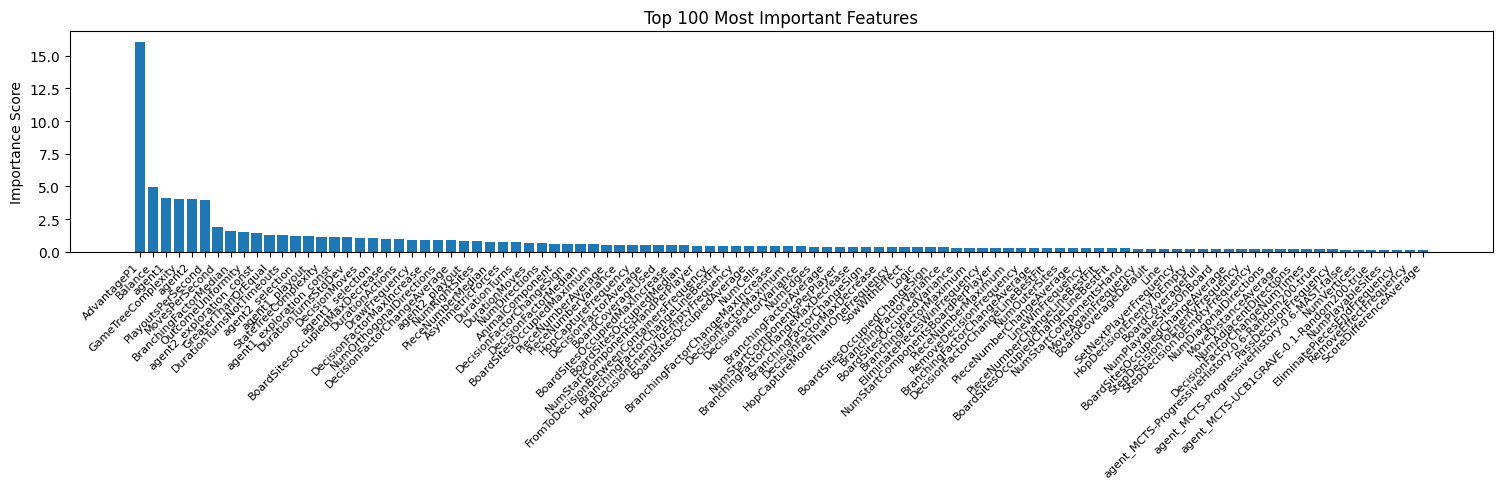

Fold 4 - RMSE: 0.4368555008593669
Fold 5


0:	learn: 0.6046526	test: 0.5857387	best: 0.5857387 (0)	total: 85.9ms	remaining: 4m 17s


50:	learn: 0.3833366	test: 0.4883668	best: 0.4883668 (50)	total: 5.17s	remaining: 4m 58s


100:	learn: 0.3456668	test: 0.4674325	best: 0.4674325 (100)	total: 10.6s	remaining: 5m 4s


150:	learn: 0.3236519	test: 0.4598053	best: 0.4598053 (150)	total: 16s	remaining: 5m 1s


200:	learn: 0.3096735	test: 0.4557008	best: 0.4557008 (200)	total: 21.5s	remaining: 4m 59s


250:	learn: 0.2976094	test: 0.4525148	best: 0.4525148 (250)	total: 26.9s	remaining: 4m 54s


300:	learn: 0.2878986	test: 0.4505603	best: 0.4505603 (300)	total: 32.4s	remaining: 4m 50s


350:	learn: 0.2794059	test: 0.4494891	best: 0.4494891 (350)	total: 37.8s	remaining: 4m 45s


400:	learn: 0.2717957	test: 0.4479483	best: 0.4479483 (400)	total: 43.2s	remaining: 4m 39s


450:	learn: 0.2655203	test: 0.4470133	best: 0.4469308 (443)	total: 48.5s	remaining: 4m 34s


500:	learn: 0.2602400	test: 0.4460403	best: 0.4460383 (499)	total: 54.1s	remaining: 4m 29s


550:	learn: 0.2552002	test: 0.4451838	best: 0.4451781 (549)	total: 59.5s	remaining: 4m 24s


600:	learn: 0.2508125	test: 0.4446111	best: 0.4446111 (600)	total: 1m 4s	remaining: 4m 19s


650:	learn: 0.2468013	test: 0.4439407	best: 0.4439407 (650)	total: 1m 10s	remaining: 4m 14s


700:	learn: 0.2430873	test: 0.4431967	best: 0.4431906 (693)	total: 1m 15s	remaining: 4m 8s


750:	learn: 0.2399892	test: 0.4429908	best: 0.4429731 (747)	total: 1m 21s	remaining: 4m 3s


800:	learn: 0.2365201	test: 0.4427722	best: 0.4427540 (799)	total: 1m 26s	remaining: 3m 58s


850:	learn: 0.2337619	test: 0.4426331	best: 0.4425884 (845)	total: 1m 32s	remaining: 3m 53s


900:	learn: 0.2307680	test: 0.4420321	best: 0.4420162 (899)	total: 1m 37s	remaining: 3m 47s


950:	learn: 0.2281041	test: 0.4418171	best: 0.4418072 (947)	total: 1m 43s	remaining: 3m 42s


1000:	learn: 0.2252673	test: 0.4417442	best: 0.4417442 (1000)	total: 1m 48s	remaining: 3m 37s


1050:	learn: 0.2227612	test: 0.4415638	best: 0.4415497 (1048)	total: 1m 54s	remaining: 3m 32s


1100:	learn: 0.2205485	test: 0.4412746	best: 0.4412493 (1097)	total: 1m 59s	remaining: 3m 26s


1150:	learn: 0.2181351	test: 0.4409316	best: 0.4409316 (1150)	total: 2m 5s	remaining: 3m 21s


1200:	learn: 0.2157814	test: 0.4406424	best: 0.4406369 (1199)	total: 2m 10s	remaining: 3m 15s


1250:	learn: 0.2137020	test: 0.4404581	best: 0.4404581 (1250)	total: 2m 16s	remaining: 3m 10s


1300:	learn: 0.2116579	test: 0.4403406	best: 0.4403018 (1296)	total: 2m 21s	remaining: 3m 5s


1350:	learn: 0.2098078	test: 0.4403041	best: 0.4403018 (1296)	total: 2m 27s	remaining: 2m 59s


1400:	learn: 0.2078259	test: 0.4402664	best: 0.4402180 (1382)	total: 2m 32s	remaining: 2m 54s


1450:	learn: 0.2058347	test: 0.4400598	best: 0.4400598 (1450)	total: 2m 38s	remaining: 2m 48s


1500:	learn: 0.2042018	test: 0.4400009	best: 0.4399816 (1493)	total: 2m 43s	remaining: 2m 43s


1550:	learn: 0.2026445	test: 0.4399598	best: 0.4399238 (1524)	total: 2m 49s	remaining: 2m 38s


1600:	learn: 0.2010588	test: 0.4399684	best: 0.4399068 (1560)	total: 2m 54s	remaining: 2m 32s


1650:	learn: 0.1994485	test: 0.4399630	best: 0.4399000 (1634)	total: 3m	remaining: 2m 27s


1700:	learn: 0.1978707	test: 0.4398885	best: 0.4398728 (1694)	total: 3m 6s	remaining: 2m 22s


1750:	learn: 0.1964213	test: 0.4397195	best: 0.4396807 (1733)	total: 3m 11s	remaining: 2m 16s


1800:	learn: 0.1950395	test: 0.4397714	best: 0.4396807 (1733)	total: 3m 17s	remaining: 2m 11s


1850:	learn: 0.1935309	test: 0.4397507	best: 0.4396807 (1733)	total: 3m 22s	remaining: 2m 5s


1900:	learn: 0.1921082	test: 0.4397623	best: 0.4396807 (1733)	total: 3m 28s	remaining: 2m


1950:	learn: 0.1907077	test: 0.4397039	best: 0.4396794 (1942)	total: 3m 33s	remaining: 1m 54s


2000:	learn: 0.1892454	test: 0.4396860	best: 0.4396633 (1974)	total: 3m 39s	remaining: 1m 49s


2050:	learn: 0.1879917	test: 0.4396474	best: 0.4396379 (2017)	total: 3m 44s	remaining: 1m 43s


2100:	learn: 0.1865746	test: 0.4395760	best: 0.4395760 (2100)	total: 3m 50s	remaining: 1m 38s


2150:	learn: 0.1851504	test: 0.4395325	best: 0.4395066 (2145)	total: 3m 55s	remaining: 1m 32s


2200:	learn: 0.1839080	test: 0.4394920	best: 0.4394859 (2159)	total: 4m 1s	remaining: 1m 27s


2250:	learn: 0.1827074	test: 0.4395274	best: 0.4394598 (2228)	total: 4m 6s	remaining: 1m 22s


2300:	learn: 0.1815016	test: 0.4394623	best: 0.4394530 (2298)	total: 4m 12s	remaining: 1m 16s


2350:	learn: 0.1802741	test: 0.4394488	best: 0.4394127 (2325)	total: 4m 17s	remaining: 1m 11s


2400:	learn: 0.1789854	test: 0.4394415	best: 0.4394127 (2325)	total: 4m 23s	remaining: 1m 5s


2450:	learn: 0.1777721	test: 0.4394370	best: 0.4394127 (2325)	total: 4m 28s	remaining: 1m


2500:	learn: 0.1765493	test: 0.4393785	best: 0.4393720 (2493)	total: 4m 34s	remaining: 54.7s


2550:	learn: 0.1753338	test: 0.4394318	best: 0.4393317 (2515)	total: 4m 39s	remaining: 49.3s


2600:	learn: 0.1741145	test: 0.4393872	best: 0.4393317 (2515)	total: 4m 45s	remaining: 43.8s


2650:	learn: 0.1729918	test: 0.4393118	best: 0.4393116 (2649)	total: 4m 51s	remaining: 38.3s


2700:	learn: 0.1717549	test: 0.4393309	best: 0.4392910 (2653)	total: 4m 56s	remaining: 32.8s


2750:	learn: 0.1707632	test: 0.4392930	best: 0.4392910 (2653)	total: 5m 2s	remaining: 27.3s


2800:	learn: 0.1696160	test: 0.4392499	best: 0.4392392 (2797)	total: 5m 7s	remaining: 21.9s


2850:	learn: 0.1686357	test: 0.4392008	best: 0.4392008 (2850)	total: 5m 13s	remaining: 16.4s


2900:	learn: 0.1675219	test: 0.4391400	best: 0.4391400 (2900)	total: 5m 18s	remaining: 10.9s


2950:	learn: 0.1664312	test: 0.4391835	best: 0.4391172 (2915)	total: 5m 24s	remaining: 5.38s


2999:	learn: 0.1654478	test: 0.4391684	best: 0.4391172 (2915)	total: 5m 29s	remaining: 0us

bestTest = 0.4391171981
bestIteration = 2915

Shrink model to first 2916 iterations.


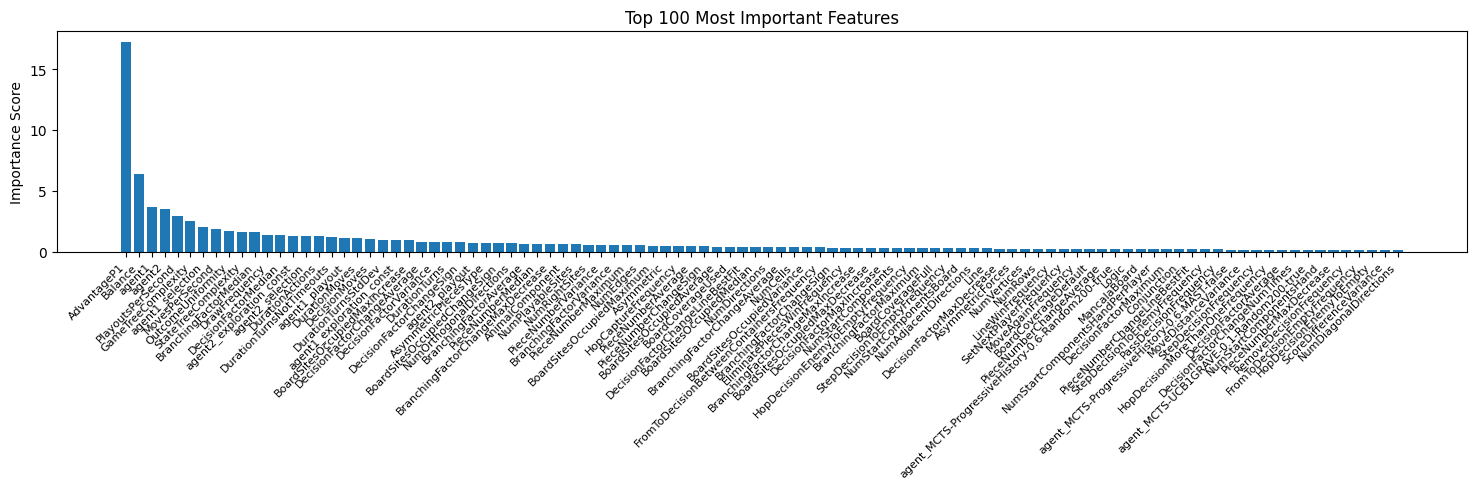

Fold 5 - RMSE: 0.43845829312211215
List of oof scores: [0.4120705515526439, 0.39659996358696037, 0.42529769969824005, 0.4368555008593669, 0.43845829312211215]
Average oof score: 0.4218564017638647


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6101090	test: 0.5693764	best: 0.5693764 (0)	total: 81.8ms	remaining: 4m 5s


50:	learn: 0.3876952	test: 0.4651696	best: 0.4651696 (50)	total: 5.19s	remaining: 5m


100:	learn: 0.3466002	test: 0.4465145	best: 0.4465145 (100)	total: 10.7s	remaining: 5m 6s


150:	learn: 0.3231485	test: 0.4389131	best: 0.4389017 (148)	total: 16.2s	remaining: 5m 4s


200:	learn: 0.3081129	test: 0.4348461	best: 0.4347709 (197)	total: 21.6s	remaining: 5m 1s


250:	learn: 0.2973238	test: 0.4329688	best: 0.4329688 (250)	total: 27.1s	remaining: 4m 57s


300:	learn: 0.2877202	test: 0.4316025	best: 0.4316025 (300)	total: 32.6s	remaining: 4m 52s


350:	learn: 0.2797883	test: 0.4301867	best: 0.4301784 (349)	total: 38.2s	remaining: 4m 48s


400:	learn: 0.2724590	test: 0.4290123	best: 0.4289881 (398)	total: 43.7s	remaining: 4m 43s


450:	learn: 0.2664977	test: 0.4281815	best: 0.4281815 (450)	total: 49.2s	remaining: 4m 38s


500:	learn: 0.2607286	test: 0.4273660	best: 0.4272976 (497)	total: 54.8s	remaining: 4m 33s


550:	learn: 0.2559689	test: 0.4269191	best: 0.4269160 (548)	total: 1m	remaining: 4m 28s


600:	learn: 0.2518755	test: 0.4265487	best: 0.4265487 (600)	total: 1m 5s	remaining: 4m 23s


650:	learn: 0.2477170	test: 0.4264749	best: 0.4263511 (626)	total: 1m 11s	remaining: 4m 17s


700:	learn: 0.2439092	test: 0.4262774	best: 0.4262757 (699)	total: 1m 17s	remaining: 4m 12s


750:	learn: 0.2401205	test: 0.4259489	best: 0.4259445 (735)	total: 1m 22s	remaining: 4m 7s


800:	learn: 0.2369228	test: 0.4256489	best: 0.4256003 (793)	total: 1m 28s	remaining: 4m 1s


850:	learn: 0.2341868	test: 0.4255872	best: 0.4255619 (810)	total: 1m 33s	remaining: 3m 56s


900:	learn: 0.2312461	test: 0.4254195	best: 0.4254081 (897)	total: 1m 39s	remaining: 3m 51s


950:	learn: 0.2286097	test: 0.4254698	best: 0.4254081 (897)	total: 1m 44s	remaining: 3m 46s


1000:	learn: 0.2261678	test: 0.4254165	best: 0.4253465 (977)	total: 1m 50s	remaining: 3m 40s


1050:	learn: 0.2238571	test: 0.4254481	best: 0.4253465 (977)	total: 1m 56s	remaining: 3m 35s


1100:	learn: 0.2216821	test: 0.4253332	best: 0.4253159 (1099)	total: 2m 1s	remaining: 3m 30s


1150:	learn: 0.2194645	test: 0.4252369	best: 0.4252311 (1132)	total: 2m 7s	remaining: 3m 24s


1200:	learn: 0.2172128	test: 0.4253012	best: 0.4252311 (1132)	total: 2m 12s	remaining: 3m 19s


1250:	learn: 0.2152260	test: 0.4253137	best: 0.4252311 (1132)	total: 2m 18s	remaining: 3m 13s


1300:	learn: 0.2132143	test: 0.4253415	best: 0.4252311 (1132)	total: 2m 24s	remaining: 3m 8s


1350:	learn: 0.2112565	test: 0.4250856	best: 0.4250786 (1344)	total: 2m 29s	remaining: 3m 2s


1400:	learn: 0.2095871	test: 0.4249816	best: 0.4249791 (1399)	total: 2m 35s	remaining: 2m 57s


1450:	learn: 0.2077639	test: 0.4249531	best: 0.4249383 (1414)	total: 2m 41s	remaining: 2m 51s


1500:	learn: 0.2060031	test: 0.4249707	best: 0.4249383 (1414)	total: 2m 46s	remaining: 2m 46s


1550:	learn: 0.2042748	test: 0.4248633	best: 0.4248633 (1550)	total: 2m 52s	remaining: 2m 40s


1600:	learn: 0.2027099	test: 0.4249205	best: 0.4248633 (1550)	total: 2m 57s	remaining: 2m 35s


1650:	learn: 0.2010075	test: 0.4248255	best: 0.4248255 (1650)	total: 3m 3s	remaining: 2m 29s


1700:	learn: 0.1993513	test: 0.4248682	best: 0.4248118 (1667)	total: 3m 9s	remaining: 2m 24s


1750:	learn: 0.1978356	test: 0.4246669	best: 0.4246643 (1747)	total: 3m 14s	remaining: 2m 18s


1800:	learn: 0.1963907	test: 0.4246031	best: 0.4246031 (1800)	total: 3m 20s	remaining: 2m 13s


1850:	learn: 0.1948233	test: 0.4245848	best: 0.4245772 (1849)	total: 3m 26s	remaining: 2m 7s


1900:	learn: 0.1934047	test: 0.4246473	best: 0.4245730 (1853)	total: 3m 31s	remaining: 2m 2s


1950:	learn: 0.1919849	test: 0.4246415	best: 0.4245730 (1853)	total: 3m 37s	remaining: 1m 56s


2000:	learn: 0.1906466	test: 0.4247381	best: 0.4245730 (1853)	total: 3m 43s	remaining: 1m 51s


2050:	learn: 0.1891720	test: 0.4247587	best: 0.4245730 (1853)	total: 3m 48s	remaining: 1m 45s


2100:	learn: 0.1877160	test: 0.4247770	best: 0.4245730 (1853)	total: 3m 54s	remaining: 1m 40s


2150:	learn: 0.1862898	test: 0.4248366	best: 0.4245730 (1853)	total: 4m	remaining: 1m 34s


2200:	learn: 0.1850541	test: 0.4248174	best: 0.4245730 (1853)	total: 4m 5s	remaining: 1m 29s


2250:	learn: 0.1836790	test: 0.4247693	best: 0.4245730 (1853)	total: 4m 11s	remaining: 1m 23s


2300:	learn: 0.1823739	test: 0.4247205	best: 0.4245730 (1853)	total: 4m 17s	remaining: 1m 18s


2350:	learn: 0.1810829	test: 0.4247309	best: 0.4245730 (1853)	total: 4m 22s	remaining: 1m 12s


2400:	learn: 0.1799324	test: 0.4247274	best: 0.4245730 (1853)	total: 4m 28s	remaining: 1m 6s


2450:	learn: 0.1788914	test: 0.4247473	best: 0.4245730 (1853)	total: 4m 34s	remaining: 1m 1s


2500:	learn: 0.1777234	test: 0.4247432	best: 0.4245730 (1853)	total: 4m 39s	remaining: 55.8s


2550:	learn: 0.1765489	test: 0.4247621	best: 0.4245730 (1853)	total: 4m 45s	remaining: 50.3s


2600:	learn: 0.1753887	test: 0.4246967	best: 0.4245730 (1853)	total: 4m 51s	remaining: 44.7s


2650:	learn: 0.1741121	test: 0.4247258	best: 0.4245730 (1853)	total: 4m 56s	remaining: 39.1s


2700:	learn: 0.1730169	test: 0.4247851	best: 0.4245730 (1853)	total: 5m 2s	remaining: 33.5s


2750:	learn: 0.1719224	test: 0.4247971	best: 0.4245730 (1853)	total: 5m 8s	remaining: 27.9s


2800:	learn: 0.1707424	test: 0.4248091	best: 0.4245730 (1853)	total: 5m 13s	remaining: 22.3s


2850:	learn: 0.1695290	test: 0.4248437	best: 0.4245730 (1853)	total: 5m 19s	remaining: 16.7s


2900:	learn: 0.1685510	test: 0.4247917	best: 0.4245730 (1853)	total: 5m 24s	remaining: 11.1s


2950:	learn: 0.1675102	test: 0.4247905	best: 0.4245730 (1853)	total: 5m 30s	remaining: 5.49s


2999:	learn: 0.1664463	test: 0.4248205	best: 0.4245730 (1853)	total: 5m 36s	remaining: 0us

bestTest = 0.4245729547
bestIteration = 1853

Shrink model to first 1854 iterations.


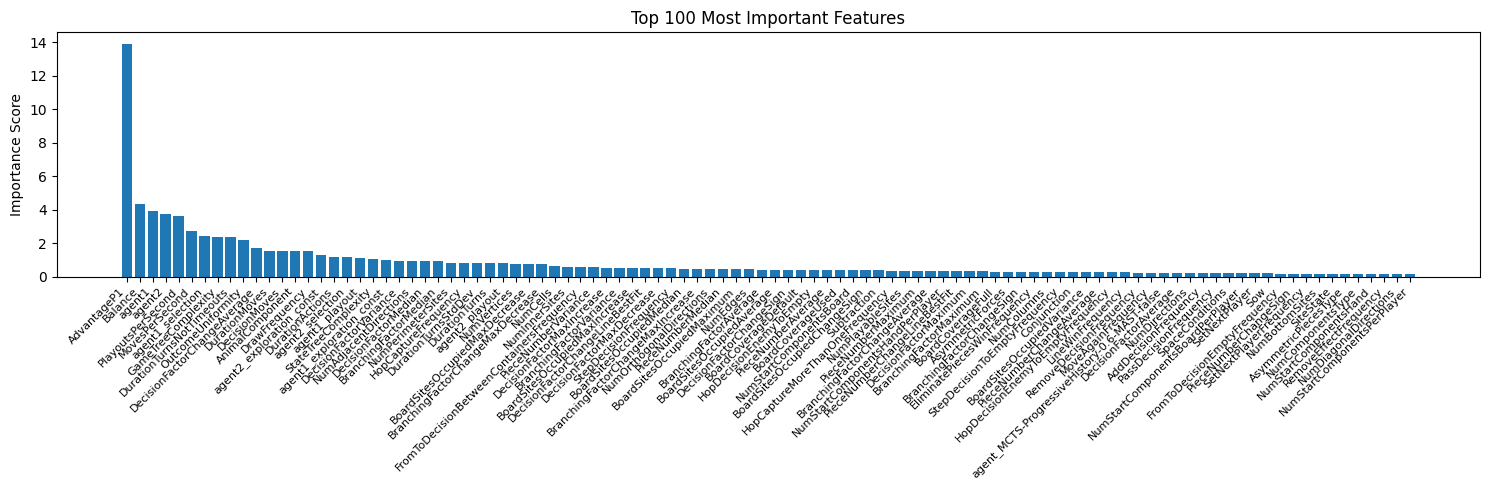

Fold 1 - RMSE: 0.42409385464289123
Fold 2


0:	learn: 0.6072756	test: 0.5691873	best: 0.5691873 (0)	total: 97.1ms	remaining: 4m 51s


50:	learn: 0.3869052	test: 0.4589400	best: 0.4589400 (50)	total: 5.37s	remaining: 5m 10s


100:	learn: 0.3489160	test: 0.4395186	best: 0.4395186 (100)	total: 11s	remaining: 5m 16s


150:	learn: 0.3281742	test: 0.4305417	best: 0.4305417 (150)	total: 16.6s	remaining: 5m 13s


200:	learn: 0.3121887	test: 0.4252755	best: 0.4252755 (200)	total: 22.3s	remaining: 5m 10s


250:	learn: 0.3000627	test: 0.4219231	best: 0.4219231 (250)	total: 27.8s	remaining: 5m 4s


300:	learn: 0.2895191	test: 0.4197454	best: 0.4197454 (300)	total: 33.4s	remaining: 4m 59s


350:	learn: 0.2815860	test: 0.4174511	best: 0.4174424 (349)	total: 39s	remaining: 4m 54s


400:	learn: 0.2740086	test: 0.4157491	best: 0.4157442 (399)	total: 44.6s	remaining: 4m 48s


450:	learn: 0.2676696	test: 0.4146815	best: 0.4146815 (450)	total: 50.2s	remaining: 4m 43s


500:	learn: 0.2619556	test: 0.4135539	best: 0.4135539 (500)	total: 55.8s	remaining: 4m 38s


550:	learn: 0.2567680	test: 0.4130757	best: 0.4130362 (549)	total: 1m 1s	remaining: 4m 33s


600:	learn: 0.2523905	test: 0.4126006	best: 0.4125948 (597)	total: 1m 7s	remaining: 4m 27s


650:	learn: 0.2480664	test: 0.4118781	best: 0.4118781 (650)	total: 1m 12s	remaining: 4m 22s


700:	learn: 0.2444829	test: 0.4115293	best: 0.4115293 (700)	total: 1m 18s	remaining: 4m 17s


750:	learn: 0.2409736	test: 0.4112318	best: 0.4111750 (747)	total: 1m 23s	remaining: 4m 11s


800:	learn: 0.2375913	test: 0.4108321	best: 0.4108321 (800)	total: 1m 29s	remaining: 4m 6s


850:	learn: 0.2346531	test: 0.4103050	best: 0.4102777 (845)	total: 1m 35s	remaining: 4m


900:	learn: 0.2318131	test: 0.4100862	best: 0.4100532 (895)	total: 1m 41s	remaining: 3m 55s


950:	learn: 0.2292693	test: 0.4098828	best: 0.4098632 (946)	total: 1m 46s	remaining: 3m 49s


1000:	learn: 0.2265108	test: 0.4095269	best: 0.4095269 (1000)	total: 1m 52s	remaining: 3m 44s


1050:	learn: 0.2239639	test: 0.4093828	best: 0.4093828 (1050)	total: 1m 58s	remaining: 3m 39s


1100:	learn: 0.2217105	test: 0.4092163	best: 0.4091953 (1097)	total: 2m 3s	remaining: 3m 33s


1150:	learn: 0.2193282	test: 0.4090637	best: 0.4090431 (1144)	total: 2m 9s	remaining: 3m 27s


1200:	learn: 0.2171307	test: 0.4087296	best: 0.4087218 (1199)	total: 2m 14s	remaining: 3m 22s


1250:	learn: 0.2149489	test: 0.4086504	best: 0.4086438 (1248)	total: 2m 20s	remaining: 3m 16s


1300:	learn: 0.2128289	test: 0.4085230	best: 0.4085230 (1300)	total: 2m 26s	remaining: 3m 10s


1350:	learn: 0.2110638	test: 0.4084634	best: 0.4084634 (1350)	total: 2m 31s	remaining: 3m 5s


1400:	learn: 0.2091833	test: 0.4084551	best: 0.4084008 (1376)	total: 2m 37s	remaining: 2m 59s


1450:	learn: 0.2074440	test: 0.4084462	best: 0.4084008 (1376)	total: 2m 43s	remaining: 2m 54s


1500:	learn: 0.2056572	test: 0.4082629	best: 0.4082589 (1496)	total: 2m 48s	remaining: 2m 48s


1550:	learn: 0.2040992	test: 0.4081844	best: 0.4081059 (1527)	total: 2m 54s	remaining: 2m 43s


1600:	learn: 0.2023496	test: 0.4082046	best: 0.4081059 (1527)	total: 3m	remaining: 2m 37s


1650:	learn: 0.2007328	test: 0.4081117	best: 0.4081059 (1527)	total: 3m 5s	remaining: 2m 31s


1700:	learn: 0.1992512	test: 0.4080326	best: 0.4080326 (1700)	total: 3m 11s	remaining: 2m 26s


1750:	learn: 0.1976330	test: 0.4080414	best: 0.4080042 (1710)	total: 3m 17s	remaining: 2m 20s


1800:	learn: 0.1960729	test: 0.4080219	best: 0.4079860 (1769)	total: 3m 22s	remaining: 2m 15s


1850:	learn: 0.1945348	test: 0.4080306	best: 0.4079860 (1769)	total: 3m 28s	remaining: 2m 9s


1900:	learn: 0.1931681	test: 0.4079464	best: 0.4079169 (1895)	total: 3m 34s	remaining: 2m 3s


1950:	learn: 0.1916456	test: 0.4079115	best: 0.4078394 (1935)	total: 3m 39s	remaining: 1m 58s


2000:	learn: 0.1902421	test: 0.4078487	best: 0.4078394 (1935)	total: 3m 45s	remaining: 1m 52s


2050:	learn: 0.1890153	test: 0.4077756	best: 0.4077754 (2048)	total: 3m 51s	remaining: 1m 47s


2100:	learn: 0.1876017	test: 0.4077226	best: 0.4077040 (2090)	total: 3m 56s	remaining: 1m 41s


2150:	learn: 0.1863845	test: 0.4076695	best: 0.4076496 (2142)	total: 4m 2s	remaining: 1m 35s


2200:	learn: 0.1849530	test: 0.4075767	best: 0.4075760 (2198)	total: 4m 8s	remaining: 1m 30s


2250:	learn: 0.1837086	test: 0.4074382	best: 0.4074382 (2250)	total: 4m 14s	remaining: 1m 24s


2300:	learn: 0.1824585	test: 0.4074420	best: 0.4074212 (2279)	total: 4m 19s	remaining: 1m 18s


2350:	learn: 0.1812847	test: 0.4072863	best: 0.4072863 (2350)	total: 4m 25s	remaining: 1m 13s


2400:	learn: 0.1799460	test: 0.4072268	best: 0.4072249 (2396)	total: 4m 31s	remaining: 1m 7s


2450:	learn: 0.1788374	test: 0.4072220	best: 0.4071780 (2426)	total: 4m 36s	remaining: 1m 1s


2500:	learn: 0.1776290	test: 0.4072106	best: 0.4071720 (2490)	total: 4m 42s	remaining: 56.3s


2550:	learn: 0.1765443	test: 0.4071947	best: 0.4071720 (2490)	total: 4m 48s	remaining: 50.7s


2600:	learn: 0.1752238	test: 0.4072184	best: 0.4071720 (2490)	total: 4m 53s	remaining: 45s


2650:	learn: 0.1741308	test: 0.4071791	best: 0.4071720 (2490)	total: 4m 59s	remaining: 39.4s


2700:	learn: 0.1730207	test: 0.4070930	best: 0.4070930 (2700)	total: 5m 4s	remaining: 33.8s


2750:	learn: 0.1718583	test: 0.4070774	best: 0.4070774 (2750)	total: 5m 10s	remaining: 28.1s


2800:	learn: 0.1707053	test: 0.4070191	best: 0.4070121 (2799)	total: 5m 16s	remaining: 22.5s


2850:	learn: 0.1698028	test: 0.4070566	best: 0.4070052 (2812)	total: 5m 22s	remaining: 16.8s


2900:	learn: 0.1688656	test: 0.4070786	best: 0.4070052 (2812)	total: 5m 27s	remaining: 11.2s


2950:	learn: 0.1678104	test: 0.4070495	best: 0.4070052 (2812)	total: 5m 33s	remaining: 5.54s


2999:	learn: 0.1666815	test: 0.4070230	best: 0.4070052 (2812)	total: 5m 38s	remaining: 0us

bestTest = 0.4070052214
bestIteration = 2812

Shrink model to first 2813 iterations.


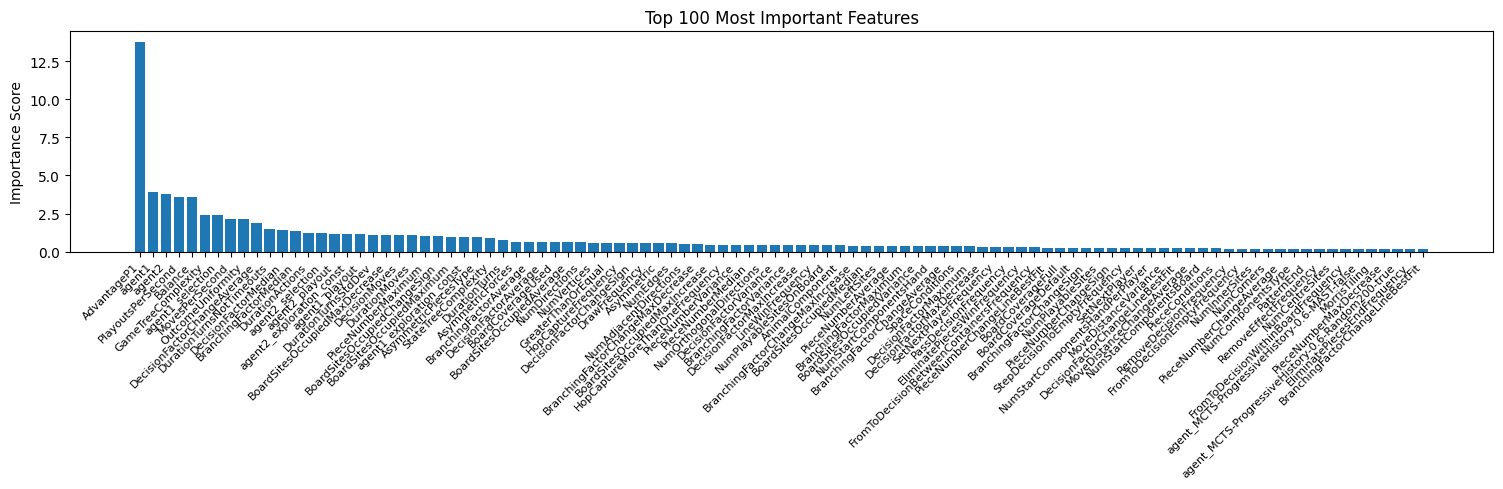

Fold 2 - RMSE: 0.40656271603390154
Fold 3


0:	learn: 0.6107532	test: 0.5698235	best: 0.5698235 (0)	total: 100ms	remaining: 4m 59s


50:	learn: 0.3868462	test: 0.4618956	best: 0.4618956 (50)	total: 5.21s	remaining: 5m 1s


100:	learn: 0.3470225	test: 0.4470755	best: 0.4470755 (100)	total: 10.6s	remaining: 5m 5s


150:	learn: 0.3232828	test: 0.4388227	best: 0.4388227 (150)	total: 16s	remaining: 5m 1s


200:	learn: 0.3094583	test: 0.4361889	best: 0.4361284 (199)	total: 21.4s	remaining: 4m 58s


250:	learn: 0.2983888	test: 0.4325875	best: 0.4325823 (249)	total: 26.9s	remaining: 4m 54s


300:	learn: 0.2891199	test: 0.4302710	best: 0.4302710 (300)	total: 32.3s	remaining: 4m 49s


350:	learn: 0.2807572	test: 0.4286264	best: 0.4285467 (347)	total: 37.8s	remaining: 4m 45s


400:	learn: 0.2730854	test: 0.4269353	best: 0.4269353 (400)	total: 43.3s	remaining: 4m 40s


450:	learn: 0.2668646	test: 0.4260890	best: 0.4259592 (443)	total: 48.7s	remaining: 4m 35s


500:	learn: 0.2615122	test: 0.4255477	best: 0.4255477 (500)	total: 54.2s	remaining: 4m 30s


550:	learn: 0.2560447	test: 0.4249484	best: 0.4249173 (546)	total: 59.6s	remaining: 4m 24s


600:	learn: 0.2518805	test: 0.4245164	best: 0.4245133 (598)	total: 1m 5s	remaining: 4m 19s


650:	learn: 0.2471557	test: 0.4239278	best: 0.4239278 (650)	total: 1m 10s	remaining: 4m 14s


700:	learn: 0.2432775	test: 0.4237686	best: 0.4237118 (694)	total: 1m 15s	remaining: 4m 9s


750:	learn: 0.2396519	test: 0.4232646	best: 0.4232631 (749)	total: 1m 21s	remaining: 4m 3s


800:	learn: 0.2364647	test: 0.4230084	best: 0.4230084 (800)	total: 1m 26s	remaining: 3m 58s


850:	learn: 0.2335395	test: 0.4227565	best: 0.4227399 (844)	total: 1m 32s	remaining: 3m 53s


900:	learn: 0.2307242	test: 0.4224651	best: 0.4224651 (900)	total: 1m 37s	remaining: 3m 48s


950:	learn: 0.2277426	test: 0.4222007	best: 0.4222007 (950)	total: 1m 43s	remaining: 3m 42s


1000:	learn: 0.2251842	test: 0.4220013	best: 0.4219972 (999)	total: 1m 48s	remaining: 3m 37s


1050:	learn: 0.2227956	test: 0.4218760	best: 0.4218196 (1041)	total: 1m 54s	remaining: 3m 32s


1100:	learn: 0.2203257	test: 0.4216323	best: 0.4216323 (1100)	total: 1m 59s	remaining: 3m 26s


1150:	learn: 0.2181907	test: 0.4214417	best: 0.4214417 (1150)	total: 2m 5s	remaining: 3m 21s


1200:	learn: 0.2162001	test: 0.4213878	best: 0.4213516 (1193)	total: 2m 10s	remaining: 3m 16s


1250:	learn: 0.2138613	test: 0.4213367	best: 0.4213363 (1249)	total: 2m 16s	remaining: 3m 10s


1300:	learn: 0.2116639	test: 0.4212825	best: 0.4212825 (1300)	total: 2m 21s	remaining: 3m 5s


1350:	learn: 0.2096354	test: 0.4212692	best: 0.4212427 (1339)	total: 2m 27s	remaining: 2m 59s


1400:	learn: 0.2076721	test: 0.4211843	best: 0.4211759 (1397)	total: 2m 32s	remaining: 2m 54s


1450:	learn: 0.2056699	test: 0.4210754	best: 0.4210402 (1447)	total: 2m 38s	remaining: 2m 49s


1500:	learn: 0.2037983	test: 0.4210064	best: 0.4209928 (1479)	total: 2m 44s	remaining: 2m 43s


1550:	learn: 0.2020318	test: 0.4209704	best: 0.4209302 (1521)	total: 2m 49s	remaining: 2m 38s


1600:	learn: 0.2003266	test: 0.4208424	best: 0.4208235 (1597)	total: 2m 54s	remaining: 2m 32s


1650:	learn: 0.1986338	test: 0.4207745	best: 0.4207485 (1641)	total: 3m	remaining: 2m 27s


1700:	learn: 0.1968072	test: 0.4206963	best: 0.4206925 (1696)	total: 3m 5s	remaining: 2m 21s


1750:	learn: 0.1951419	test: 0.4208063	best: 0.4206722 (1708)	total: 3m 11s	remaining: 2m 16s


1800:	learn: 0.1936594	test: 0.4207414	best: 0.4206722 (1708)	total: 3m 16s	remaining: 2m 11s


1850:	learn: 0.1920256	test: 0.4206910	best: 0.4206722 (1708)	total: 3m 22s	remaining: 2m 5s


1900:	learn: 0.1903745	test: 0.4206051	best: 0.4206023 (1895)	total: 3m 27s	remaining: 2m


1950:	learn: 0.1888322	test: 0.4207034	best: 0.4205980 (1901)	total: 3m 33s	remaining: 1m 54s


2000:	learn: 0.1872908	test: 0.4206307	best: 0.4205980 (1901)	total: 3m 38s	remaining: 1m 49s


2050:	learn: 0.1858514	test: 0.4206429	best: 0.4205980 (1901)	total: 3m 44s	remaining: 1m 43s


2100:	learn: 0.1844791	test: 0.4206424	best: 0.4205980 (1901)	total: 3m 49s	remaining: 1m 38s


2150:	learn: 0.1831301	test: 0.4205742	best: 0.4205568 (2135)	total: 3m 55s	remaining: 1m 32s


2200:	learn: 0.1816230	test: 0.4204622	best: 0.4204622 (2200)	total: 4m	remaining: 1m 27s


2250:	learn: 0.1803739	test: 0.4204510	best: 0.4204481 (2206)	total: 4m 6s	remaining: 1m 21s


2300:	learn: 0.1791499	test: 0.4204278	best: 0.4204169 (2271)	total: 4m 11s	remaining: 1m 16s


2350:	learn: 0.1778059	test: 0.4203269	best: 0.4203097 (2330)	total: 4m 17s	remaining: 1m 10s


2400:	learn: 0.1765242	test: 0.4202909	best: 0.4202720 (2396)	total: 4m 22s	remaining: 1m 5s


2450:	learn: 0.1751984	test: 0.4203300	best: 0.4202720 (2396)	total: 4m 28s	remaining: 1m


2500:	learn: 0.1739036	test: 0.4202603	best: 0.4202603 (2500)	total: 4m 33s	remaining: 54.6s


2550:	learn: 0.1726183	test: 0.4203118	best: 0.4202464 (2502)	total: 4m 38s	remaining: 49.1s


2600:	learn: 0.1714183	test: 0.4202456	best: 0.4202456 (2600)	total: 4m 44s	remaining: 43.6s


2650:	learn: 0.1702285	test: 0.4202256	best: 0.4202148 (2639)	total: 4m 49s	remaining: 38.2s


2700:	learn: 0.1690976	test: 0.4202477	best: 0.4202148 (2639)	total: 4m 55s	remaining: 32.7s


2750:	learn: 0.1679842	test: 0.4202255	best: 0.4202089 (2730)	total: 5m	remaining: 27.2s


2800:	learn: 0.1669492	test: 0.4202208	best: 0.4202089 (2730)	total: 5m 6s	remaining: 21.8s


2850:	learn: 0.1657433	test: 0.4202091	best: 0.4202089 (2730)	total: 5m 11s	remaining: 16.3s


2900:	learn: 0.1646232	test: 0.4201257	best: 0.4201066 (2888)	total: 5m 17s	remaining: 10.8s


2950:	learn: 0.1636255	test: 0.4201326	best: 0.4201066 (2888)	total: 5m 22s	remaining: 5.36s


2999:	learn: 0.1627523	test: 0.4200909	best: 0.4200874 (2996)	total: 5m 28s	remaining: 0us

bestTest = 0.4200873709
bestIteration = 2996

Shrink model to first 2997 iterations.


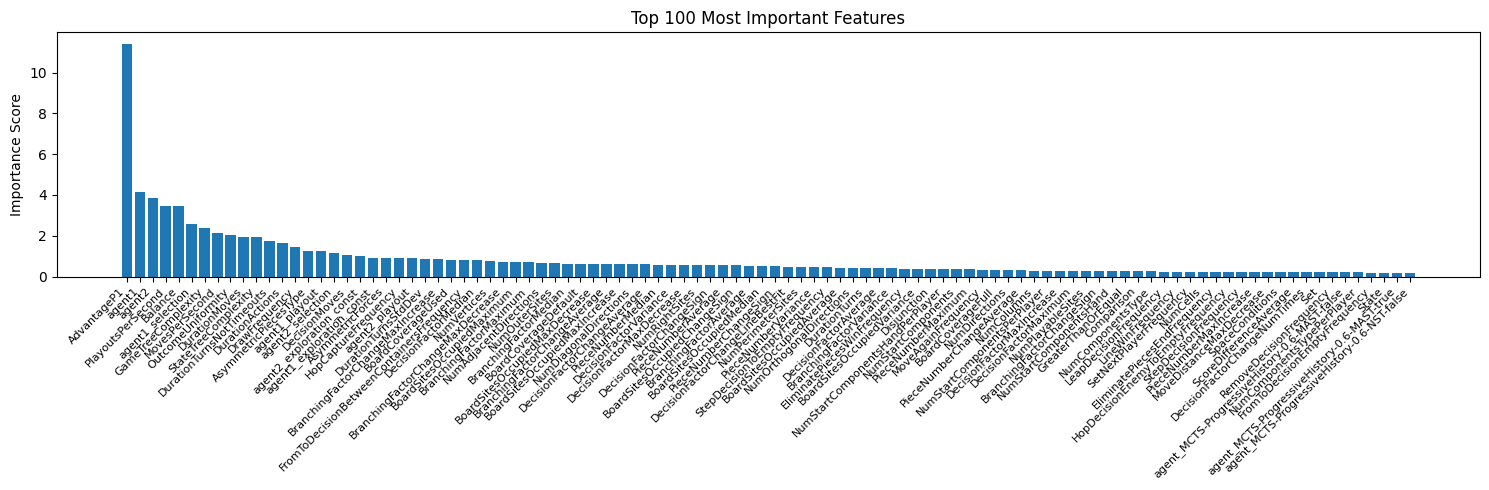

Fold 3 - RMSE: 0.41969975159431616
Fold 4


0:	learn: 0.6099124	test: 0.5672263	best: 0.5672263 (0)	total: 104ms	remaining: 5m 12s


50:	learn: 0.3891111	test: 0.4582140	best: 0.4582140 (50)	total: 5.04s	remaining: 4m 51s


100:	learn: 0.3483035	test: 0.4430880	best: 0.4430880 (100)	total: 10.5s	remaining: 5m 2s


150:	learn: 0.3259402	test: 0.4378710	best: 0.4378710 (150)	total: 15.9s	remaining: 5m


200:	learn: 0.3096853	test: 0.4340042	best: 0.4340042 (200)	total: 21.3s	remaining: 4m 56s


250:	learn: 0.2978432	test: 0.4313560	best: 0.4313353 (248)	total: 26.8s	remaining: 4m 53s


300:	learn: 0.2879723	test: 0.4296273	best: 0.4296273 (300)	total: 32.3s	remaining: 4m 49s


350:	learn: 0.2804036	test: 0.4282869	best: 0.4282869 (350)	total: 37.9s	remaining: 4m 45s


400:	learn: 0.2732172	test: 0.4278285	best: 0.4278259 (381)	total: 43.3s	remaining: 4m 40s


450:	learn: 0.2667550	test: 0.4269435	best: 0.4269435 (450)	total: 48.7s	remaining: 4m 35s


500:	learn: 0.2611586	test: 0.4264961	best: 0.4264961 (500)	total: 54.1s	remaining: 4m 29s


550:	learn: 0.2563393	test: 0.4257574	best: 0.4257574 (550)	total: 59.7s	remaining: 4m 25s


600:	learn: 0.2516094	test: 0.4250550	best: 0.4250550 (600)	total: 1m 5s	remaining: 4m 19s


650:	learn: 0.2473874	test: 0.4244345	best: 0.4244244 (649)	total: 1m 10s	remaining: 4m 14s


700:	learn: 0.2435692	test: 0.4241532	best: 0.4241444 (699)	total: 1m 16s	remaining: 4m 9s


750:	learn: 0.2397679	test: 0.4238438	best: 0.4238438 (750)	total: 1m 21s	remaining: 4m 3s


800:	learn: 0.2366582	test: 0.4235404	best: 0.4235404 (800)	total: 1m 27s	remaining: 3m 58s


850:	learn: 0.2336729	test: 0.4234056	best: 0.4233847 (825)	total: 1m 32s	remaining: 3m 53s


900:	learn: 0.2310636	test: 0.4231284	best: 0.4231028 (896)	total: 1m 37s	remaining: 3m 48s


950:	learn: 0.2286269	test: 0.4229864	best: 0.4229864 (950)	total: 1m 43s	remaining: 3m 42s


1000:	learn: 0.2257267	test: 0.4229720	best: 0.4229222 (972)	total: 1m 48s	remaining: 3m 37s


1050:	learn: 0.2231787	test: 0.4229591	best: 0.4229157 (1002)	total: 1m 54s	remaining: 3m 32s


1100:	learn: 0.2209552	test: 0.4229067	best: 0.4229019 (1095)	total: 1m 59s	remaining: 3m 26s


1150:	learn: 0.2187096	test: 0.4227559	best: 0.4227559 (1150)	total: 2m 5s	remaining: 3m 21s


1200:	learn: 0.2165552	test: 0.4226498	best: 0.4226055 (1188)	total: 2m 11s	remaining: 3m 16s


1250:	learn: 0.2144915	test: 0.4227235	best: 0.4226055 (1188)	total: 2m 16s	remaining: 3m 10s


1300:	learn: 0.2124655	test: 0.4226884	best: 0.4226055 (1188)	total: 2m 22s	remaining: 3m 5s


1350:	learn: 0.2103316	test: 0.4225646	best: 0.4225397 (1341)	total: 2m 27s	remaining: 3m


1400:	learn: 0.2085315	test: 0.4225904	best: 0.4225159 (1358)	total: 2m 33s	remaining: 2m 54s


1450:	learn: 0.2067315	test: 0.4225640	best: 0.4225159 (1358)	total: 2m 38s	remaining: 2m 49s


1500:	learn: 0.2049923	test: 0.4224371	best: 0.4224264 (1497)	total: 2m 44s	remaining: 2m 43s


1550:	learn: 0.2033092	test: 0.4223691	best: 0.4223419 (1523)	total: 2m 49s	remaining: 2m 38s


1600:	learn: 0.2016107	test: 0.4223892	best: 0.4223121 (1564)	total: 2m 55s	remaining: 2m 32s


1650:	learn: 0.1998493	test: 0.4223111	best: 0.4222822 (1642)	total: 3m	remaining: 2m 27s


1700:	learn: 0.1981514	test: 0.4221860	best: 0.4221803 (1694)	total: 3m 5s	remaining: 2m 22s


1750:	learn: 0.1965338	test: 0.4222388	best: 0.4221720 (1705)	total: 3m 11s	remaining: 2m 16s


1800:	learn: 0.1949371	test: 0.4222637	best: 0.4221720 (1705)	total: 3m 16s	remaining: 2m 11s


1850:	learn: 0.1934734	test: 0.4222025	best: 0.4221720 (1705)	total: 3m 22s	remaining: 2m 5s


1900:	learn: 0.1919481	test: 0.4222028	best: 0.4221720 (1705)	total: 3m 27s	remaining: 2m


1950:	learn: 0.1905053	test: 0.4222308	best: 0.4221720 (1705)	total: 3m 33s	remaining: 1m 54s


2000:	learn: 0.1891132	test: 0.4221734	best: 0.4221544 (1996)	total: 3m 38s	remaining: 1m 49s


2050:	learn: 0.1878091	test: 0.4220772	best: 0.4220772 (2050)	total: 3m 44s	remaining: 1m 43s


2100:	learn: 0.1863835	test: 0.4220005	best: 0.4220005 (2100)	total: 3m 50s	remaining: 1m 38s


2150:	learn: 0.1848845	test: 0.4219385	best: 0.4219369 (2149)	total: 3m 55s	remaining: 1m 32s


2200:	learn: 0.1834992	test: 0.4219120	best: 0.4218948 (2181)	total: 4m	remaining: 1m 27s


2250:	learn: 0.1821876	test: 0.4219079	best: 0.4218607 (2228)	total: 4m 6s	remaining: 1m 21s


2300:	learn: 0.1808104	test: 0.4218823	best: 0.4218547 (2284)	total: 4m 11s	remaining: 1m 16s


2350:	learn: 0.1795328	test: 0.4217477	best: 0.4217448 (2348)	total: 4m 17s	remaining: 1m 11s


2400:	learn: 0.1782760	test: 0.4216531	best: 0.4216518 (2391)	total: 4m 22s	remaining: 1m 5s


2450:	learn: 0.1770473	test: 0.4216242	best: 0.4216130 (2438)	total: 4m 28s	remaining: 1m


2500:	learn: 0.1759718	test: 0.4216470	best: 0.4216127 (2452)	total: 4m 33s	remaining: 54.7s


2550:	learn: 0.1747977	test: 0.4216870	best: 0.4216127 (2452)	total: 4m 39s	remaining: 49.2s


2600:	learn: 0.1734725	test: 0.4216731	best: 0.4216127 (2452)	total: 4m 45s	remaining: 43.7s


2650:	learn: 0.1723388	test: 0.4215970	best: 0.4215961 (2647)	total: 4m 50s	remaining: 38.2s


2700:	learn: 0.1710742	test: 0.4216623	best: 0.4215959 (2651)	total: 4m 56s	remaining: 32.8s


2750:	learn: 0.1699029	test: 0.4216644	best: 0.4215959 (2651)	total: 5m 1s	remaining: 27.3s


2800:	learn: 0.1687179	test: 0.4217363	best: 0.4215959 (2651)	total: 5m 6s	remaining: 21.8s


2850:	learn: 0.1676798	test: 0.4216912	best: 0.4215959 (2651)	total: 5m 12s	remaining: 16.3s


2900:	learn: 0.1666128	test: 0.4217276	best: 0.4215959 (2651)	total: 5m 18s	remaining: 10.9s


2950:	learn: 0.1655423	test: 0.4216749	best: 0.4215959 (2651)	total: 5m 23s	remaining: 5.37s


2999:	learn: 0.1645975	test: 0.4216734	best: 0.4215959 (2651)	total: 5m 28s	remaining: 0us

bestTest = 0.4215958521
bestIteration = 2651

Shrink model to first 2652 iterations.


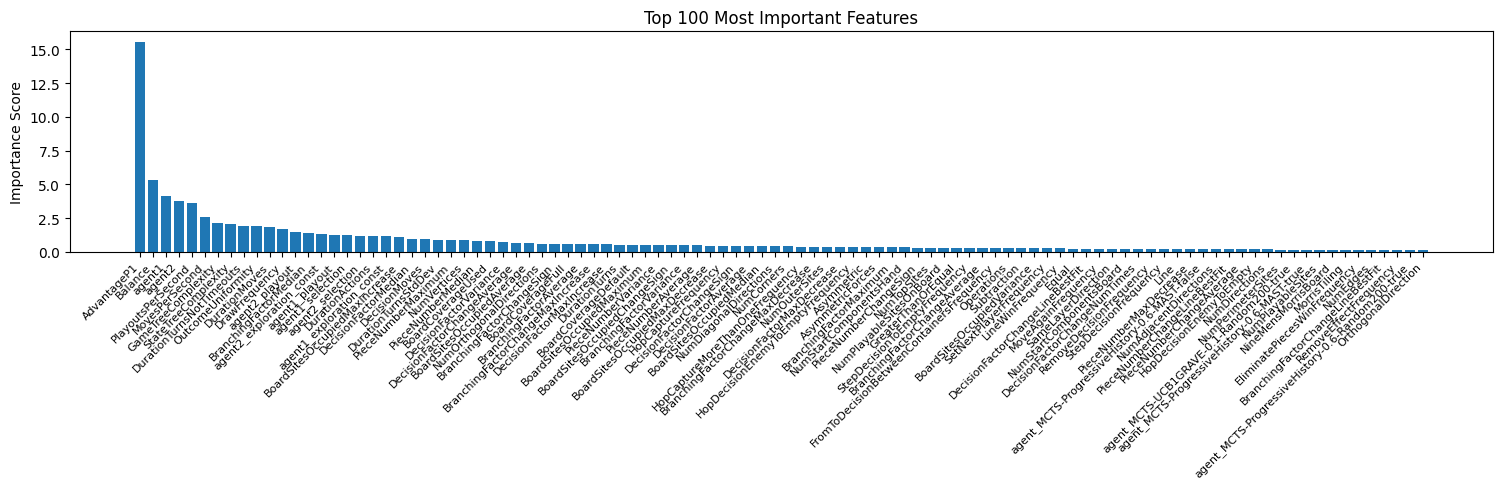

Fold 4 - RMSE: 0.42097379143283536
Fold 5


0:	learn: 0.6052621	test: 0.5793209	best: 0.5793209 (0)	total: 87ms	remaining: 4m 20s


50:	learn: 0.3872409	test: 0.4757735	best: 0.4757735 (50)	total: 5.38s	remaining: 5m 10s


100:	learn: 0.3479085	test: 0.4579644	best: 0.4579644 (100)	total: 11s	remaining: 5m 16s


150:	learn: 0.3267445	test: 0.4491927	best: 0.4490486 (149)	total: 16.6s	remaining: 5m 12s


200:	learn: 0.3120659	test: 0.4453513	best: 0.4453513 (200)	total: 22.2s	remaining: 5m 8s


250:	learn: 0.2994121	test: 0.4418912	best: 0.4418438 (246)	total: 27.6s	remaining: 5m 2s


300:	learn: 0.2895315	test: 0.4400209	best: 0.4400209 (300)	total: 33.2s	remaining: 4m 57s


350:	learn: 0.2819102	test: 0.4391892	best: 0.4391892 (350)	total: 38.7s	remaining: 4m 52s


400:	learn: 0.2744880	test: 0.4373487	best: 0.4373487 (400)	total: 44.3s	remaining: 4m 47s


450:	learn: 0.2680680	test: 0.4364165	best: 0.4364165 (450)	total: 49.8s	remaining: 4m 41s


500:	learn: 0.2621796	test: 0.4352453	best: 0.4352453 (500)	total: 55.4s	remaining: 4m 36s


550:	learn: 0.2573542	test: 0.4350088	best: 0.4348319 (538)	total: 1m 1s	remaining: 4m 31s


600:	learn: 0.2530715	test: 0.4349640	best: 0.4348319 (538)	total: 1m 6s	remaining: 4m 26s


650:	learn: 0.2485695	test: 0.4345373	best: 0.4345051 (648)	total: 1m 12s	remaining: 4m 21s


700:	learn: 0.2448206	test: 0.4343995	best: 0.4343677 (697)	total: 1m 18s	remaining: 4m 16s


750:	learn: 0.2413150	test: 0.4340667	best: 0.4340667 (750)	total: 1m 23s	remaining: 4m 10s


800:	learn: 0.2377816	test: 0.4338041	best: 0.4337832 (790)	total: 1m 29s	remaining: 4m 5s


850:	learn: 0.2343727	test: 0.4335904	best: 0.4335904 (850)	total: 1m 34s	remaining: 3m 59s


900:	learn: 0.2316061	test: 0.4332605	best: 0.4332495 (896)	total: 1m 40s	remaining: 3m 54s


950:	learn: 0.2289259	test: 0.4331715	best: 0.4331381 (924)	total: 1m 46s	remaining: 3m 48s


1000:	learn: 0.2264827	test: 0.4331023	best: 0.4330881 (982)	total: 1m 51s	remaining: 3m 43s


1050:	learn: 0.2241704	test: 0.4330593	best: 0.4330291 (1045)	total: 1m 57s	remaining: 3m 37s


1100:	learn: 0.2218985	test: 0.4330861	best: 0.4330069 (1063)	total: 2m 3s	remaining: 3m 32s


1150:	learn: 0.2198102	test: 0.4330395	best: 0.4330069 (1063)	total: 2m 8s	remaining: 3m 27s


1200:	learn: 0.2176967	test: 0.4329188	best: 0.4329176 (1199)	total: 2m 14s	remaining: 3m 21s


1250:	learn: 0.2156104	test: 0.4327893	best: 0.4327836 (1231)	total: 2m 20s	remaining: 3m 16s


1300:	learn: 0.2135827	test: 0.4326410	best: 0.4326375 (1297)	total: 2m 26s	remaining: 3m 10s


1350:	learn: 0.2117208	test: 0.4324884	best: 0.4324560 (1344)	total: 2m 31s	remaining: 3m 5s


1400:	learn: 0.2096853	test: 0.4323904	best: 0.4323904 (1400)	total: 2m 37s	remaining: 2m 59s


1450:	learn: 0.2078786	test: 0.4322798	best: 0.4322798 (1450)	total: 2m 43s	remaining: 2m 54s


1500:	learn: 0.2060470	test: 0.4322684	best: 0.4322570 (1499)	total: 2m 48s	remaining: 2m 48s


1550:	learn: 0.2043141	test: 0.4322451	best: 0.4322113 (1540)	total: 2m 54s	remaining: 2m 42s


1600:	learn: 0.2025133	test: 0.4322015	best: 0.4321774 (1593)	total: 3m	remaining: 2m 37s


1650:	learn: 0.2008105	test: 0.4321602	best: 0.4321238 (1646)	total: 3m 5s	remaining: 2m 31s


1700:	learn: 0.1992463	test: 0.4320693	best: 0.4320590 (1682)	total: 3m 11s	remaining: 2m 26s


1750:	learn: 0.1975902	test: 0.4321299	best: 0.4320491 (1701)	total: 3m 17s	remaining: 2m 20s


1800:	learn: 0.1960011	test: 0.4321426	best: 0.4320491 (1701)	total: 3m 22s	remaining: 2m 14s


1850:	learn: 0.1945934	test: 0.4322009	best: 0.4320491 (1701)	total: 3m 28s	remaining: 2m 9s


1900:	learn: 0.1930858	test: 0.4321527	best: 0.4320491 (1701)	total: 3m 34s	remaining: 2m 3s


1950:	learn: 0.1915713	test: 0.4320681	best: 0.4320491 (1701)	total: 3m 39s	remaining: 1m 58s


2000:	learn: 0.1901702	test: 0.4320424	best: 0.4320424 (2000)	total: 3m 45s	remaining: 1m 52s


2050:	learn: 0.1886919	test: 0.4318891	best: 0.4318884 (2049)	total: 3m 50s	remaining: 1m 46s


2100:	learn: 0.1873054	test: 0.4318698	best: 0.4318287 (2082)	total: 3m 56s	remaining: 1m 41s


2150:	learn: 0.1859309	test: 0.4317975	best: 0.4317834 (2140)	total: 4m 2s	remaining: 1m 35s


2200:	learn: 0.1846413	test: 0.4318311	best: 0.4317834 (2140)	total: 4m 7s	remaining: 1m 29s


2250:	learn: 0.1832672	test: 0.4317599	best: 0.4317524 (2233)	total: 4m 13s	remaining: 1m 24s


2300:	learn: 0.1820449	test: 0.4317450	best: 0.4317200 (2287)	total: 4m 19s	remaining: 1m 18s


2350:	learn: 0.1806481	test: 0.4316908	best: 0.4316905 (2341)	total: 4m 24s	remaining: 1m 13s


2400:	learn: 0.1794115	test: 0.4316768	best: 0.4316377 (2375)	total: 4m 30s	remaining: 1m 7s


2450:	learn: 0.1781644	test: 0.4316727	best: 0.4316377 (2375)	total: 4m 36s	remaining: 1m 1s


2500:	learn: 0.1770291	test: 0.4316312	best: 0.4316307 (2488)	total: 4m 41s	remaining: 56.2s


2550:	learn: 0.1758585	test: 0.4316103	best: 0.4315997 (2543)	total: 4m 47s	remaining: 50.6s


2600:	learn: 0.1747770	test: 0.4315865	best: 0.4315553 (2593)	total: 4m 53s	remaining: 45s


2650:	learn: 0.1736412	test: 0.4316062	best: 0.4315553 (2593)	total: 4m 59s	remaining: 39.4s


2700:	learn: 0.1724606	test: 0.4316211	best: 0.4315553 (2593)	total: 5m 4s	remaining: 33.7s


2750:	learn: 0.1714052	test: 0.4317000	best: 0.4315553 (2593)	total: 5m 10s	remaining: 28.1s


2800:	learn: 0.1703894	test: 0.4317082	best: 0.4315553 (2593)	total: 5m 16s	remaining: 22.5s


2850:	learn: 0.1692719	test: 0.4316613	best: 0.4315553 (2593)	total: 5m 21s	remaining: 16.8s


2900:	learn: 0.1681468	test: 0.4316472	best: 0.4315553 (2593)	total: 5m 27s	remaining: 11.2s


2950:	learn: 0.1669471	test: 0.4316407	best: 0.4315553 (2593)	total: 5m 32s	remaining: 5.53s


2999:	learn: 0.1659777	test: 0.4316305	best: 0.4315553 (2593)	total: 5m 38s	remaining: 0us

bestTest = 0.4315553096
bestIteration = 2593

Shrink model to first 2594 iterations.


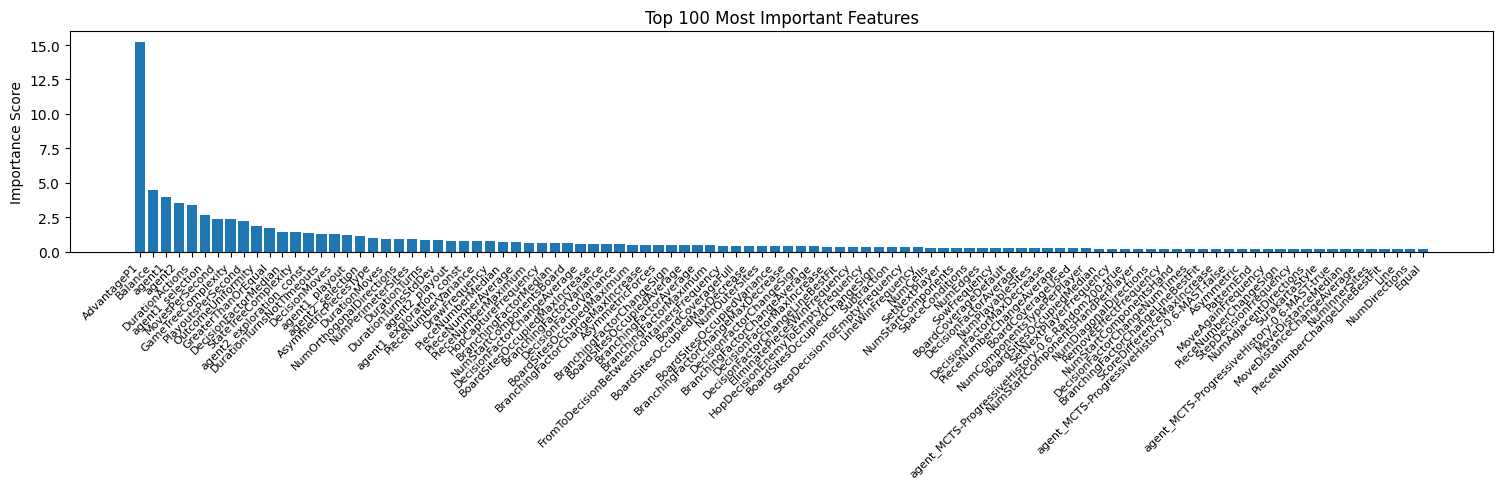

Fold 5 - RMSE: 0.43093065557173504
List of oof scores: [0.42409385464289123, 0.40656271603390154, 0.41969975159431616, 0.42097379143283536, 0.43093065557173504]
Average oof score: 0.4204521538551359


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4199
Score: 0.4469
Score: 0.4266
Score: 0.4387
Score: 0.3999
Average CV1 Score: 0.4264

CV2 OOF Scores:
Score: 0.4121
Score: 0.3966
Score: 0.4253
Score: 0.4369
Score: 0.4385
Average CV2 Score: 0.4219

CV3 OOF Scores:
Score: 0.4241
Score: 0.4066
Score: 0.4197
Score: 0.4210
Score: 0.4309
Average CV3 Score: 0.4205


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

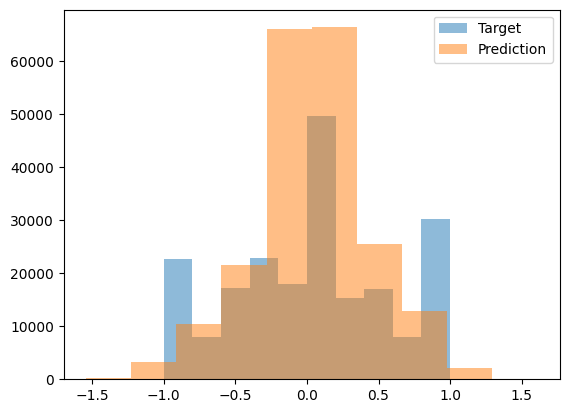

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.130797       │
│ 233235 ┆ -0.186137      │
│ 233236 ┆ 0.009529       │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***